In [87]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
from scipy.special import roots_legendre, eval_legendre
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
eps = np.finfo(float).eps

In [2]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Debye_sum_res_f
from masa_utils import Debye_sum_res_f_re
from masa_utils import Pelton_res_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular.

In [3]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=3e-2
smp_freq=50e3 #200e3  

In [4]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [5]:
tstrt, tend = 1e-4, 3e-2
logstep = 1/15

WISTEM_SP_sim = TEM_Signal_Process(
    base_freq=base_freq,
    on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq*4
)


In [6]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

6000
[5.0e-06 1.0e-05 1.5e-05] [0.02999  0.029995 0.03    ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696
 0.01       0.01165914 0.01359356 0.01584893 0.0184785  0.02154435
 0.02511886 0.02928645]


In [7]:
# csx, csz = tx_radius/4.,tx_radius/4.
con_sea = 3.0
res_sea = 1/con_sea
res0_target = 0.2
con_target = 1/res0_target
eta_sea , eta_base = 0.,0.
eta_target = 0.5
con8_target = con_target/(1-eta_target)
print(f'con8 {con8_target:.2e}')
print(f'con  {con_target:.2e}')
tau_sea, tau_base, tau_ref = 1.0e-3, 1.0e-3, 1.0e-3
tau_target = 1.0e-3
c_target = 0.4
c_sea, c_base, c_ref = 0.6,0.6,0.6
thick_target = 5.
thick_ref = 5
tx_height = 0.2 #csx
print(tx_height)

con8 1.00e+01
con  5.00e+00
0.2


In [8]:
res_base = 1.0
res_ref= res_sea
eta_sea , eta_base, eta_ref = 0.,0.,1e-3
tau_sea, tau_base, tau_ref = 1.0e-3, 1.0e-3, 1.0e-3
c_sea, c_base, c_ref = 0.6,0.6,0.6

In [9]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(38, 6000)


In [10]:
def rec_area(nquad, tx_side):
    # Get roots and weights for the Legendre quadrature
    roots, weights = roots_legendre(nquad)
    
    # Scale roots by tx_side
    scaled_roots = roots * tx_side / 2.0

    # Create grid positions for x and y
    recx = np.tile(scaled_roots, nquad)  # Repeat scaled_roots nquad times for x
    recy = np.repeat(scaled_roots, nquad)  # Repeat each element of scaled_roots nquad times for y

    # Compute weights matrix (outer product of weights) and normalize
    w_array = weights.reshape(-1, 1)  # Column vector (nquad x 1)
    w_arrayT = weights.reshape(1, -1)  # Row vector (1 x nquad)
    matrix = np.dot(w_array, w_arrayT)  # Outer product to create weights grid
    recw = matrix.reshape(1, -1)  # Flatten the matrix to a 1D row vector
    recw /= recw.sum()  # Normalize weights to ensure they sum to 1
    return recx, recy, recw


In [11]:
recx, recy, recw = rec_area(3, tx_side)
recBdple = [recx, recy, tx_depth ,0,90]

In [12]:
# tx_height = tx_radius/10.

In [13]:
nlayer=2

In [14]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    # 'depth': depth,
#    'res' : res,
    'freqtime': times_sim,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [15]:
sim_obs=empymod_IP_simulation(
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    recw=recw, m_depth=True)
sim_obs.deepsea_one_IP_layer(
    res_sea=res_sea,
    eta_sea=eta_sea, tau_sea=tau_sea, c_sea=c_sea,
    eta_base=eta_base, tau_base=tau_base, c_base=c_base 
    )
# sim_obs.fix_sea_basement(
#     res_sea=res_sea, res_base=res_seabed,
#     chg_sea=eta_sea, chg_base=eta_base,
#     tau_sea=tau_sea, tau_base=tau_base,
#     c_sea=c_sea, c_base=c_base
#     )

In [16]:
sim_obs.m_fix

array([-1.09861229,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -6.90775528,  0.        , -6.90775528,  0.6       ,
        0.        ,  0.6       ,  0.        ])

In [17]:
# res = res_sea * np.ones(nlayer)
res= np.r_[res0_target,res_base]
m_r = np.log(res)
m = eta_target * np.ones(nlayer-1)
m_m = m 
m_t = np.log(tau_target)*np.ones(nlayer-1)
m_c = c_target*np.ones(nlayer-1)
m_d = np.log(thick_target)*np.ones(nlayer-1)
mvec_obs = np.r_[m_r, m_m,m_t,m_c,m_d]
print(mvec_obs)
print(sim_obs.get_ip_model(mvec_obs))

[-1.60943791  0.          0.5        -6.90775528  0.4         1.60943791]
{'res': array([0.33333333, 0.2       , 1.        ]), 'rho_0': array([0.33333333, 0.2       , 1.        ]), 'm': array([0. , 0.5, 0. ]), 'tau': array([0.001, 0.001, 0.001]), 'c': array([0.6, 0.4, 0.6]), 'func_eta': <bound method empymod_IP_simulation.pelton_et_al of <masa_utils.empymod_IP_simulation object at 0x0000027D3CC99400>>}


In [18]:
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [19]:
sim_obs.model_base

{'src': [1.75, 1.75, 0, 1.75, 0, 0],
 'rec': [array([-1.35554417,  0.        ,  1.35554417, -1.35554417,  0.        ,
          1.35554417, -1.35554417,  0.        ,  1.35554417]),
  array([-1.35554417, -1.35554417, -1.35554417,  0.        ,  0.        ,
          0.        ,  1.35554417,  1.35554417,  1.35554417]),
  0,
  0,
  90],
 'freqtime': array([5.0000e-06, 1.0000e-05, 1.5000e-05, ..., 2.9990e-02, 2.9995e-02,
        3.0000e-02]),
 'signal': 0,
 'msrc': False,
 'mrec': True,
 'strength': 0.0006157521604388001,
 'srcpts': 3,
 'verb': 0,
 'xdirect': True,
 'depth': array([0.2, 5.2])}

In [20]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )
PL_jac = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )

PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )

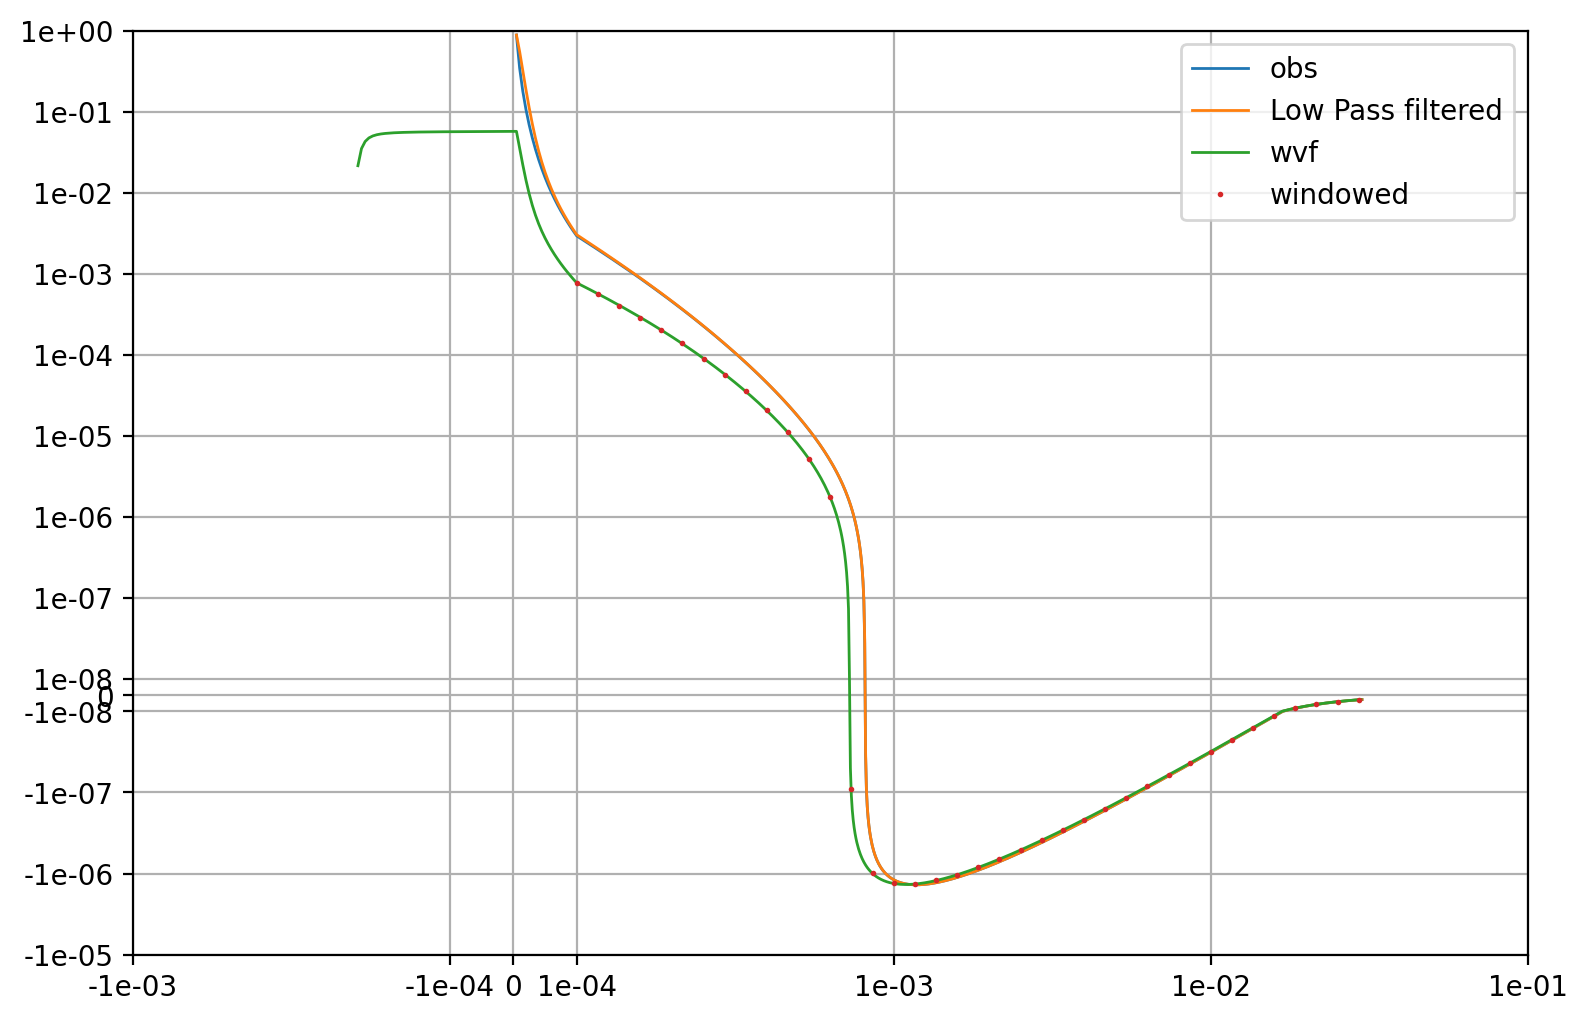

In [21]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [22]:
relative_error=0.05
data_noise_floor = 0.1e-7
dobs_clean =  sim_obs.dpred(mvec_obs)

# Calculate noise at each point according to the formula
noise_floor = np.random.randn(len(dobs_clean)) * data_noise_floor
data_noise = np.random.randn(len(dobs_clean)) * relative_error * np.abs(dobs_clean)

# Combine the two sources of noise quadratically (in terms of variance)
total_noise = np.sqrt(noise_floor**2 + data_noise**2)

# Add the combined noise to the clean data
dobs = dobs_clean + total_noise
# data_init = sim_obs.predicted_data(mvec_ref)

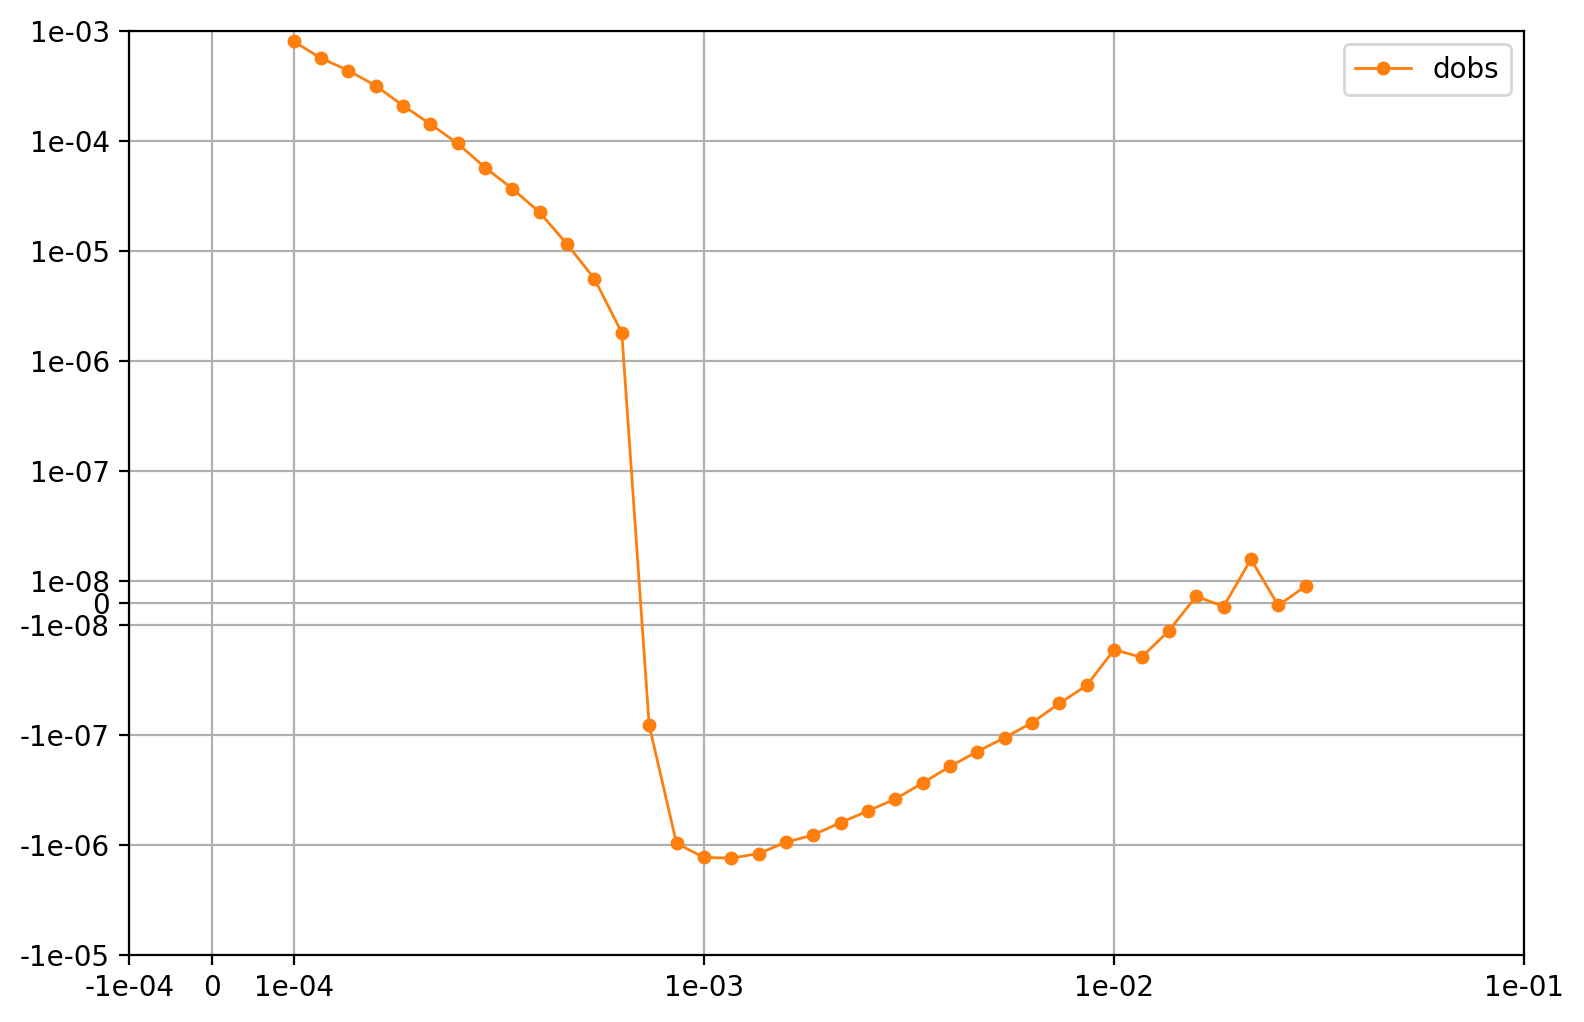

In [23]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
# ax=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=data_init,
#    label="ref/init", color="C0", marker="o",markersize=4,ax=ax
# )
ax=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
   label="dobs", color="C1", marker="o",markersize=4,ax=ax
)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [37]:
J_pelton = sim_obs.J(mvec_obs)

# Invert with Debye Sum Series config

In [24]:
taus = np.logspace(-4.0,-2.0,5)
print(taus)
#taus= np.r_[1e-2]
ntau = len(taus)


[0.0001     0.00031623 0.001      0.00316228 0.01      ]


In [25]:
# freq = np.logspace(1, 6, 9)
# etas = 0.1*np.ones(taus.shape[0])
# rho_0 = 0.2
# omega = 2*np.pi*freq
# omega = omega
# taus = taus#.reshape(1, -1)
# etas = etas#.reshape(1, -1)
# print(omega.shape)
# print(taus.shape)
# print(etas.shape)
# iwt = np.outer(1.0j*omega,taus)
# print(iwt.shape)
# # term = etas/(1.0 + iwt)
# # print(term.shape)
# # rhoH = rho_0*(1.0-etas.sum(axis=1)+term.sum(axis=1))
# # print(rhoH.shape)

In [26]:
# inp = res_ip 
# p_dict = {}
# p_dict['freq'] = freq
# etas_list = []
# for i in range(ntau):
#     etas_list.append(inp[f'm_{i}'])  # Each m_i should be [nlayer]

# etas = np.array(etas_list)  # Shape: [ntau, nlayer]

# # Reshape etas to [1, nlayer, ntau]
# etas = etas.T[None, :, :]  # Transpose to [nlayer, ntau] → add batch dim → [1, nlayer, ntau]

# # Angular frequency, reshaped to [nfreq, 1, 1]
# omega = 2.0 * np.pi * p_dict['freq']
# omega = omega.reshape(-1, 1, 1)

# # Reshape taus to [1, 1, ntau] so it broadcasts correctly
# taus = taus.reshape(1, 1, -1)

# print("omega shape:", omega.shape)  # [nfreq, 1, 1]
# print("etas shape:", etas.shape)    # [1, nlayer, ntau]
# print("taus shape:", taus.shape)    # [1, 1, ntau]

# # Compute complex frequency response: shape will be [nfreq, nlayer, ntau]
# iwt = 1.0j * omega * taus
# print("iwt shape:", iwt.shape)

# # Compute Debye term
# term = etas / (1.0 + iwt)  # shape: [nfreq, nlayer, ntau]
# print("term shape:", term.shape)

# # Compute effective resistivity
# # etas.sum(axis=2) has shape [1, nlayer], broadcasted to [nfreq, nlayer]
# rhoH = inp['rho_0'] * (1.0 - etas.sum(axis=2) + term.sum(axis=2))
# print("rhoH shape:", rhoH.shape)


In [27]:
# res ={}
# nlayer= 3
# m_list = []
# for i in range(ntau):
#     etai = 0.1*(i+1)*np.ones(nlayer) 
#     res[f"m_{i}"] = etai
#     m_list.append(etai)
# m = np.array(m_list)
# print(m.shape)
# m_sum = m.sum(axis=0)
# print(m_sum.shape)

In [28]:
sim_inv=empymod_IP_simulation(ip_model='DCS',chgmin=0,
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    recw=recw, m_depth=True, taus=taus)
sim_inv.deepsea_one_IP_layer(
    res_sea=res_sea, eta_sea=eta_sea, eta_base=eta_base  
    )

In [29]:
# res = res_sea * np.ones(nlayer)
res = np.r_[res_sea, res_sea]
m_r = np.log(res)
m_each = 0 #0.5/ntau
m =  m_each*np.ones((nlayer-1)*ntau)
m_m = m 
m_d = np.log(thick_ref)*np.ones(nlayer-1)
mvec_ref = np.r_[m_r, m_m,m_d]
print(mvec_ref)


[-1.09861229 -1.09861229  0.          0.          0.          0.
  0.          1.60943791]


In [30]:
dpred_step= sim_inv.dpred(mvec_ref)
sim_inv.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_inv.cut_off}")
dpred_LPF = sim_inv.dpred(mvec_ref)
sim_inv.filt_curr = filt_linrmp
dpred_rmp = sim_inv.dpred(mvec_ref)
sim_inv.window_mat=Window_mat
dpred_window = sim_inv.dpred(mvec_ref)

cutoff frequency: 25000.0


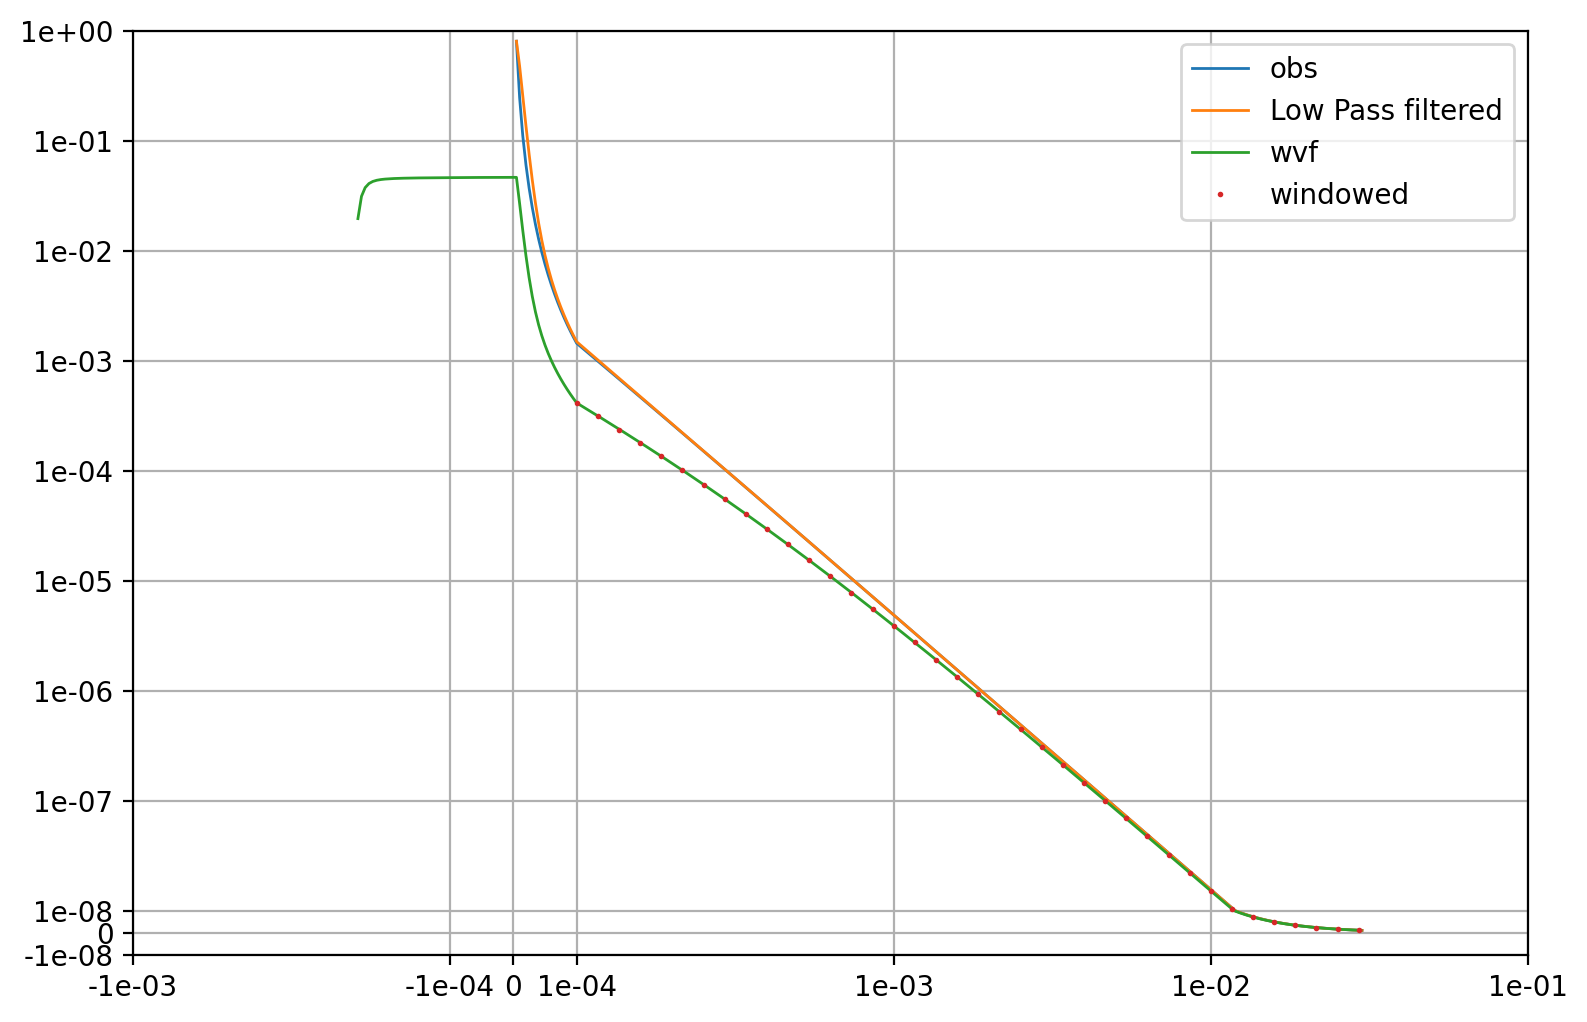

In [31]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [32]:
data_init= sim_inv.dpred(mvec_ref)
J_debye=sim_inv.J(mvec_ref)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


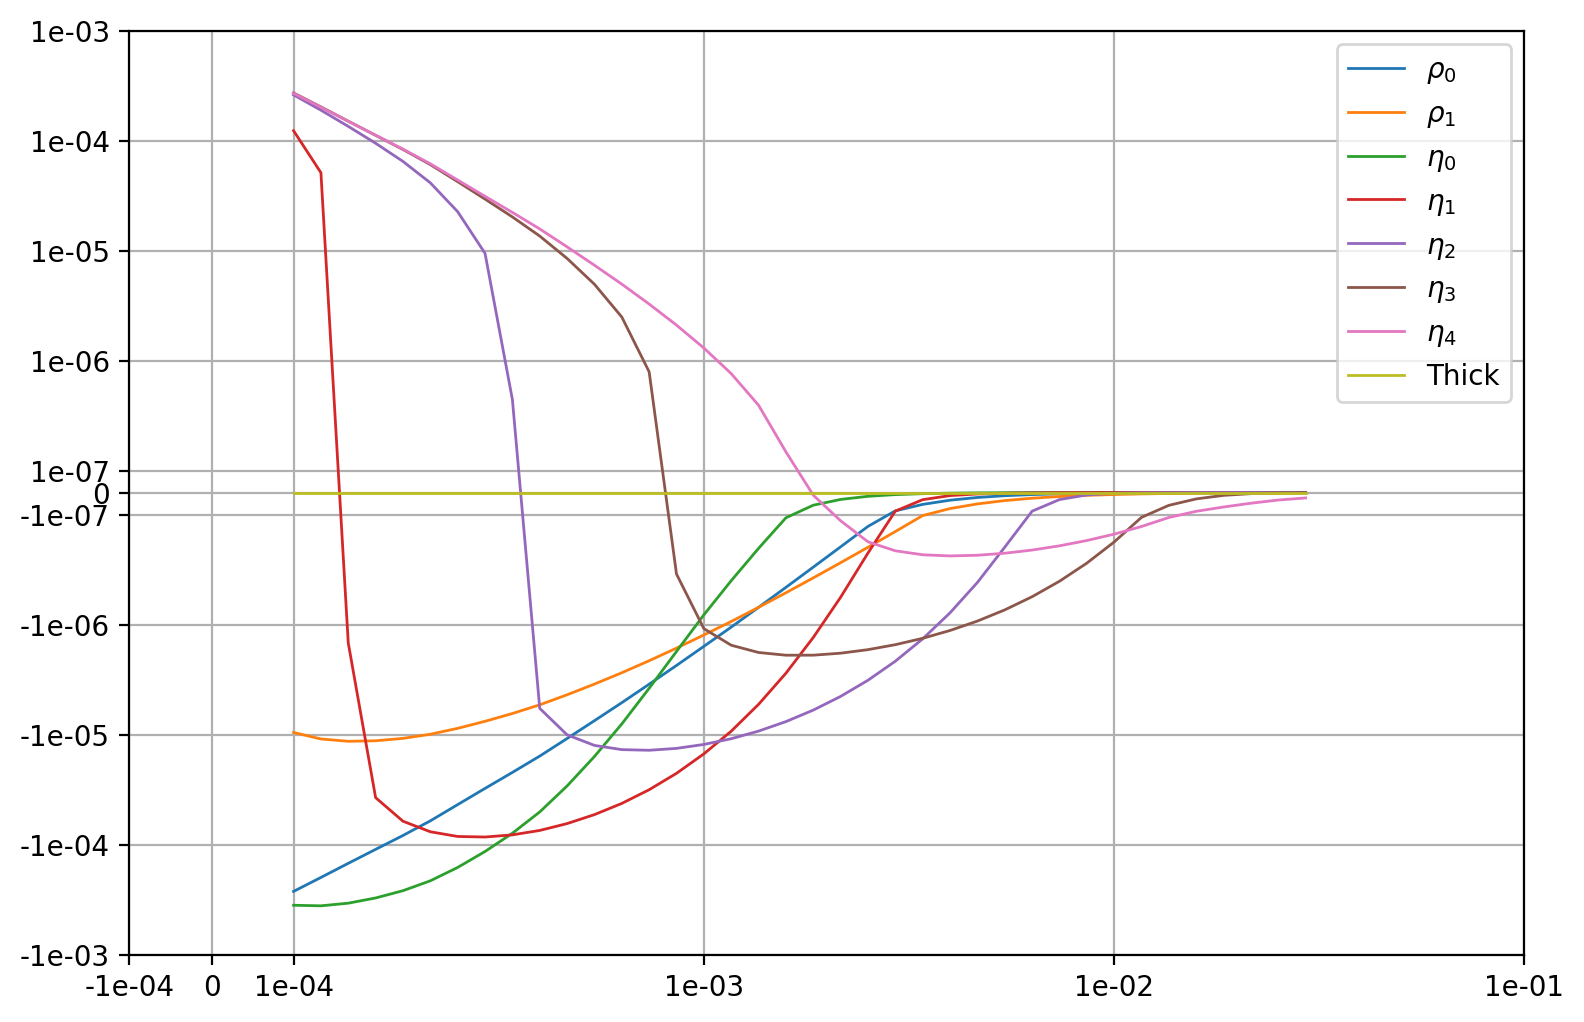

In [33]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
# ax=PL_decay.plpl_plot(
#      x= windows_cen-rmp_time,y=dpred , marker="o",linestyle="",label="windowed", color="C3",ax=ax)

for i in range(nlayer):
     ax=PL_jac.plpl_plot(
          x= windows_cen-rmp_time,y=J_debye[:,i] ,color=f"C{i}",
            linestyle="-",label=fr"$\rho_{{{i}}}$",ax=ax)
for i in range(ntau):
     ax=PL_jac.plpl_plot(
          x= windows_cen-rmp_time,y=J_debye[:,i+nlayer] ,color=f"C{i+nlayer}",
            linestyle="-",label=f"$\eta_{i}$",ax=ax)
ax=PL_jac.plpl_plot(
     x= windows_cen-rmp_time,y=J_debye[:,-1] ,color=f"C{len(mvec_ref)}",
          linestyle="-",label="Thick",ax=ax)

ax= PL_jac.pl_axes(ax)
ax = PL_jac.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [34]:
opt = Optimization(sim=sim_inv, dobs=dobs, Ws_threshold=0.05)


In [35]:
opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.get_Ws(mvec=mvec_ref)
opt.alphas = 1.0

In [38]:
Wd = opt.Wd

U, S, V = np.linalg.svd(Wd@J_pelton, full_matrices=False)
s_norm = S/S.max()
S_pelton_norm = s_norm

In [39]:
U, S, V = np.linalg.svd(Wd@J_debye, full_matrices=False)
s_norm = S/S.max()
S_debye_norm = s_norm

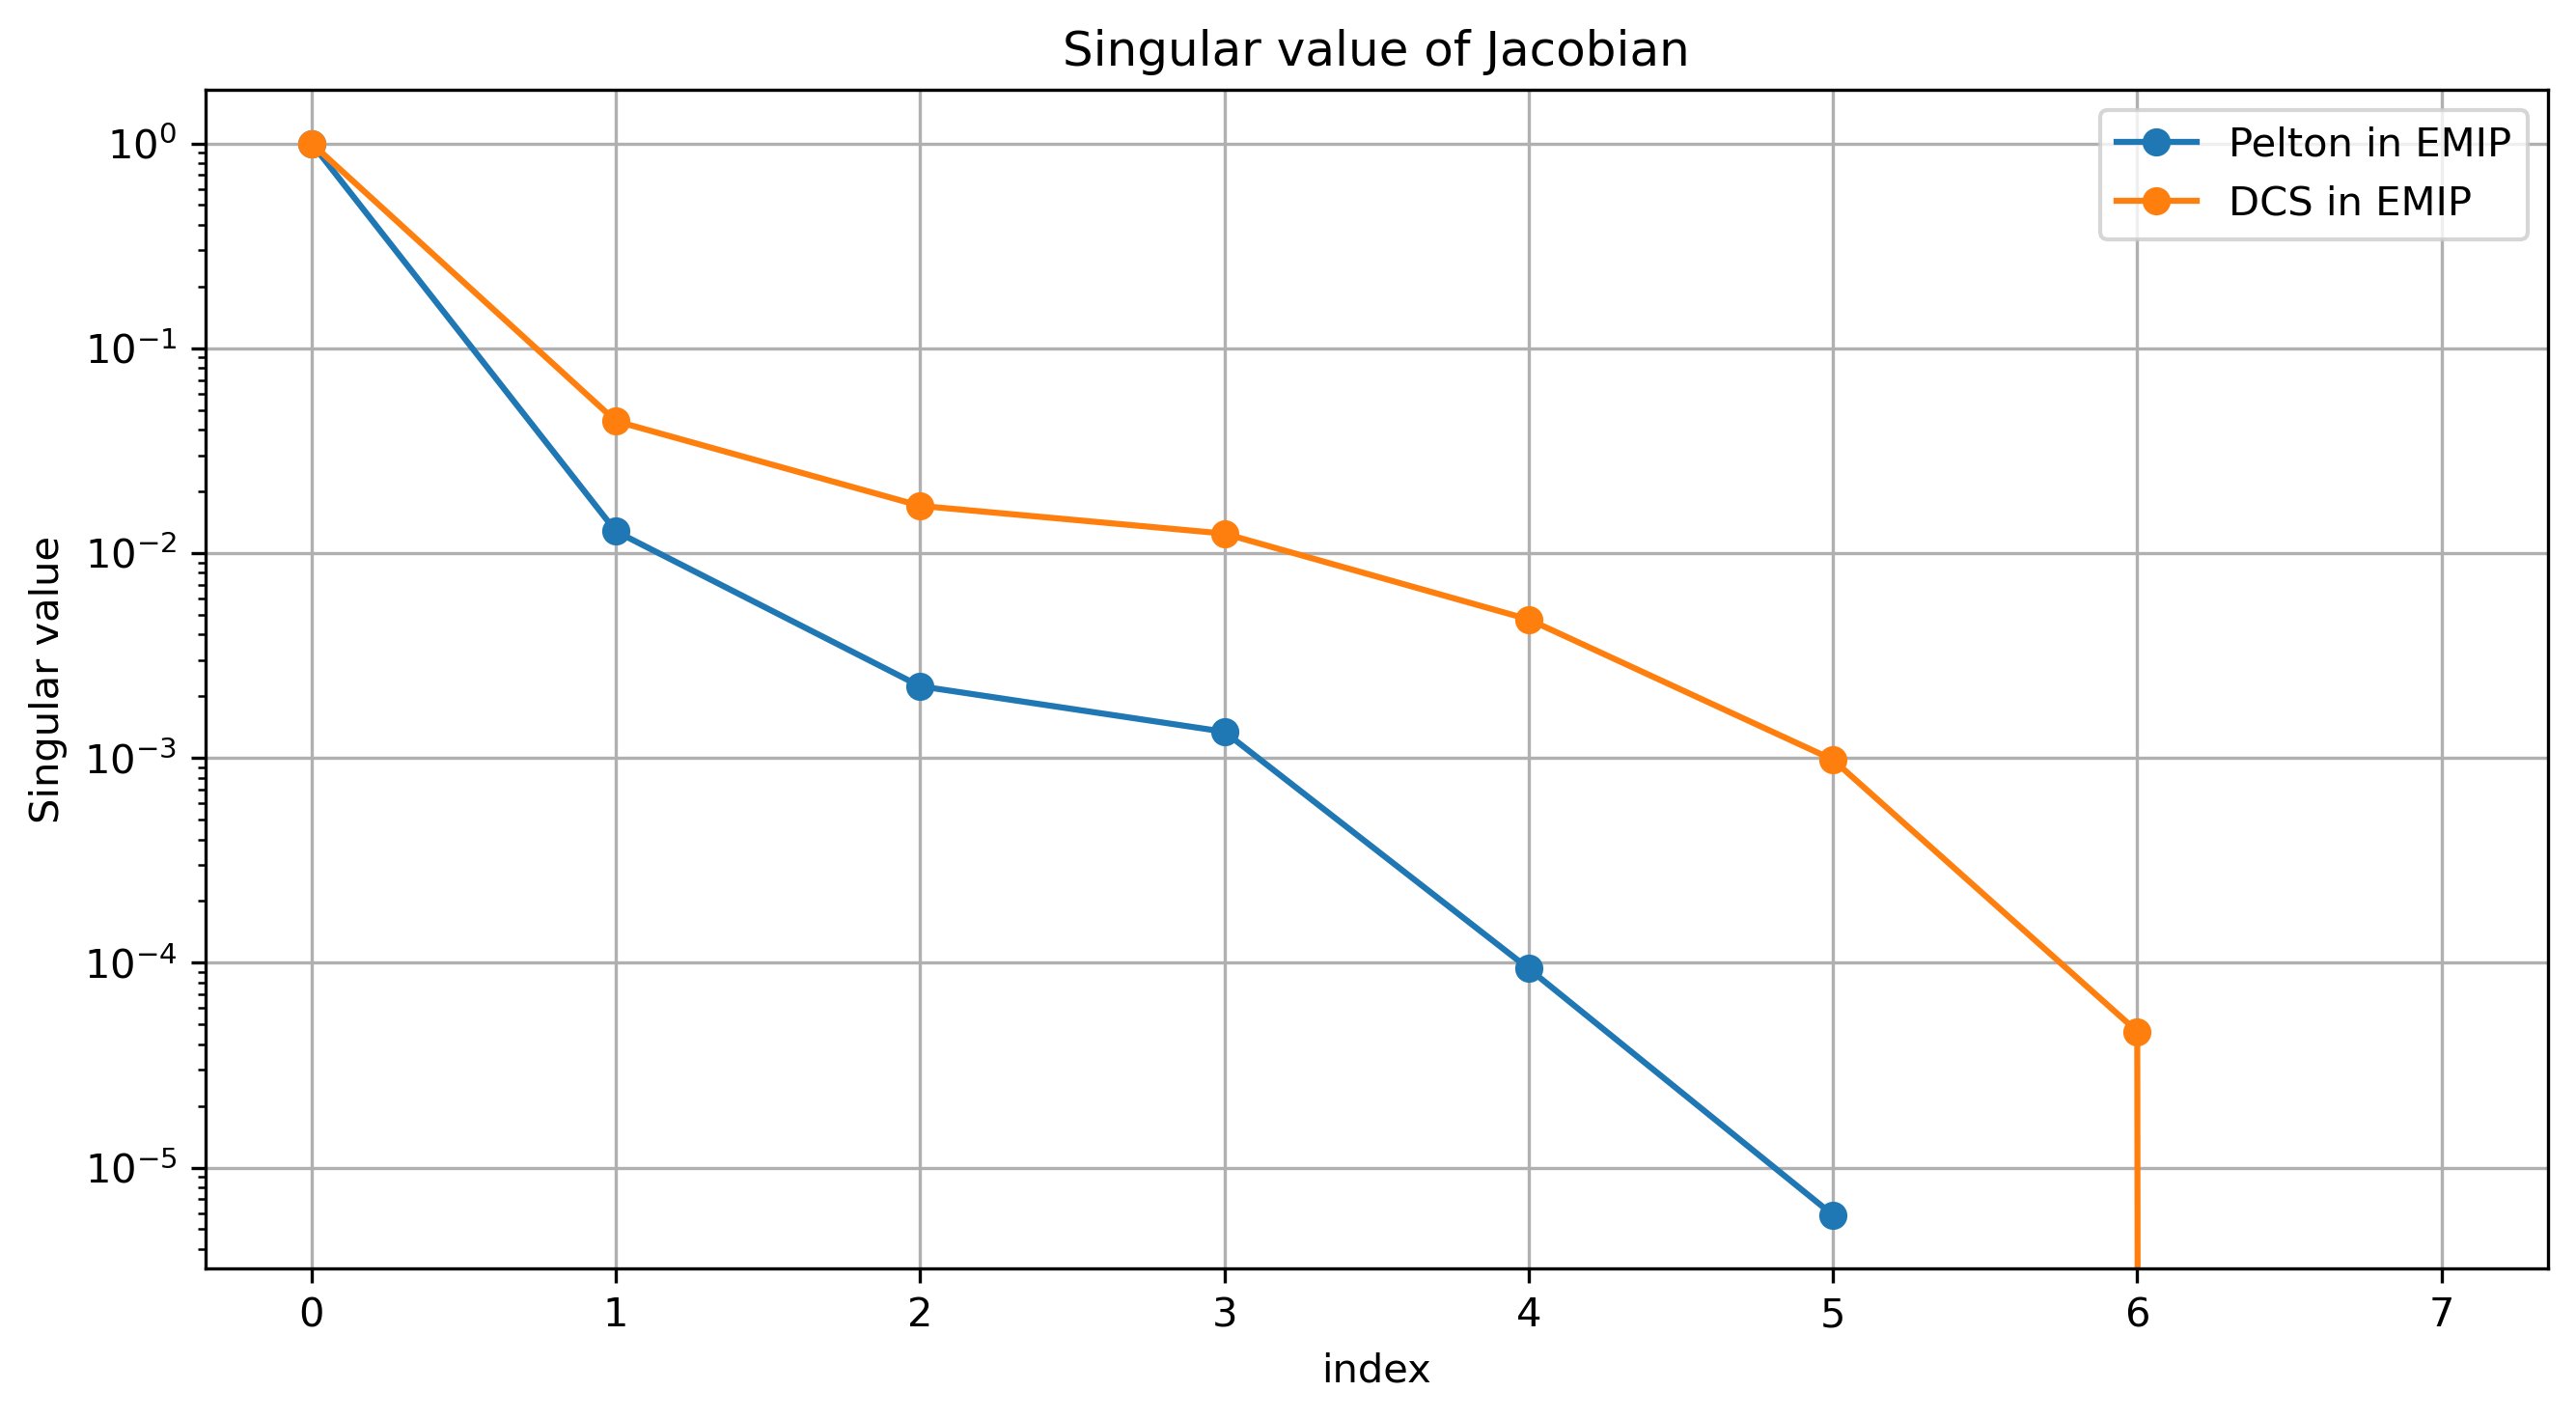

In [40]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)
# ax.semilogy(S_pelton_sip[0], label='Pelton in SIP', marker="o")
ax.semilogy(S_pelton_norm, label='Pelton in EMIP', marker="o")
ax.semilogy(S_debye_norm, label='DCS in EMIP', marker="o")
# ax.set_xticks(np.arange(ntau+1))
# ax.set_xticklabels(np.arange(1,ntau+2))
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
plt.savefig("32_Singular_Copmparison.jpg", dpi=300)

In [ ]:
beta0 = opt.BetaEstimate_byEig(mvec=mvec_ref,beta0_ratio=1, update_Wsen=True)
print(beta0)
# beta = 10
niter = 50
coolingRate=2
coolingFactor=2
stol= 1e-6
mu = 1e-3
mpred = opt.GaussNewton(
    mvec_init=mvec_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )


28550354668.533253
  1, beta:2.9e+10, step:1.0e+00, g:1.6e+07, phid:1.7e+06, phim:6.1e-07, f:1.8e+06 
  2, beta:2.9e+10, step:1.0e+00, g:1.4e+06, phid:1.7e+06, phim:6.1e-07, f:1.8e+06 
  3, beta:1.4e+10, step:1.0e+00, g:8.0e+06, phid:1.7e+06, phim:2.4e-06, f:1.7e+06 
  4, beta:1.4e+10, step:1.0e+00, g:1.3e+06, phid:1.7e+06, phim:2.4e-06, f:1.7e+06 
  5, beta:7.1e+09, step:1.0e+00, g:7.9e+06, phid:1.7e+06, phim:9.0e-06, f:1.7e+06 
  6, beta:7.1e+09, step:1.0e+00, g:1.2e+06, phid:1.7e+06, phim:8.9e-06, f:1.7e+06 
  7, beta:3.6e+09, step:1.0e+00, g:7.7e+06, phid:1.5e+06, phim:3.3e-05, f:1.7e+06 
  8, beta:3.6e+09, step:1.0e+00, g:1.0e+06, phid:1.5e+06, phim:3.2e-05, f:1.6e+06 
  9, beta:1.8e+09, step:1.0e+00, g:7.6e+06, phid:1.3e+06, phim:1.1e-04, f:1.5e+06 
 10, beta:1.8e+09, step:1.0e+00, g:8.7e+05, phid:1.3e+06, phim:1.2e-04, f:1.5e+06 
 11, beta:8.9e+08, step:1.0e+00, g:9.3e+06, phid:8.4e+05, phim:4.5e-04, f:1.2e+06 
 12, beta:8.9e+08, step:9.5e-07, g:2.1e+06, phid:8.4e+05, phim:6.0e-

In [42]:
mvec_itr = np.array(opt.mvec_prg)
data_prg = np.array(opt.data_prg)
error_prg = np.array(opt.error_prg)
nD = data_prg[0].shape[0]
cmp_itr = mvec_itr.shape[0]
data_itr = data_prg
f_obj_itr = error_prg[:,0]
phid_itr = error_prg[:,1]
phim_itr = error_prg[:,2]


In [68]:
coolingRate=2
coolingFactor=2


In [69]:
betas = []
betas.append(beta0)
for i in range(cmp_itr-1):
    beta = beta0 / (coolingFactor ** (i // coolingRate))
    betas.append(beta)
betas = np.array(betas)
print(betas)

[2.85503547e+10 2.85503547e+10 2.85503547e+10 1.42751773e+10
 1.42751773e+10 7.13758867e+09 7.13758867e+09 3.56879433e+09
 3.56879433e+09 1.78439717e+09 1.78439717e+09 8.92198583e+08
 8.92198583e+08 4.46099292e+08 4.46099292e+08 2.23049646e+08
 2.23049646e+08 1.11524823e+08 1.11524823e+08 5.57624115e+07
 5.57624115e+07 2.78812057e+07 2.78812057e+07 1.39406029e+07
 1.39406029e+07 6.97030143e+06 6.97030143e+06 3.48515072e+06
 3.48515072e+06 1.74257536e+06 1.74257536e+06 8.71287679e+05
 8.71287679e+05 4.35643840e+05 4.35643840e+05 2.17821920e+05
 2.17821920e+05 1.08910960e+05 1.08910960e+05 5.44554799e+04
 5.44554799e+04 2.72277400e+04 2.72277400e+04 1.36138700e+04
 1.36138700e+04 6.80693499e+03 6.80693499e+03 3.40346750e+03
 3.40346750e+03 1.70173375e+03 1.70173375e+03]


In [43]:
print(sim_inv.get_ip_model(mpred))
print(sim_inv.model_base)

{'res': array([0.33333333, 0.18235385, 0.52840323]), 'rho_0': array([0.33333333, 0.18235385, 0.52840323]), 'func_eta': <bound method empymod_IP_simulation.debye_sum_ser of <masa_utils.empymod_IP_simulation object at 0x0000027D3CC9CF70>>, 'm_0': array([0.        , 0.02612304, 0.        ]), 'm_1': array([0.        , 0.05820966, 0.        ]), 'm_2': array([0.        , 0.07809653, 0.        ]), 'm_3': array([0.        , 0.07389553, 0.        ]), 'm_4': array([0.        , 0.06105302, 0.        ]), 'm': array([0.        , 0.29737779, 0.        ])}
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [array([-1.35554417,  0.        ,  1.35554417, -1.35554417,  0.        ,
        1.35554417, -1.35554417,  0.        ,  1.35554417]), array([-1.35554417, -1.35554417, -1.35554417,  0.        ,  0.        ,
        0.        ,  1.35554417,  1.35554417,  1.35554417]), 0, 0, 90], 'freqtime': array([5.0000e-06, 1.0000e-05, 1.5000e-05, ..., 2.9990e-02, 2.9995e-02,
       3.0000e-02]), 'signal': 0, 'msrc': Fals

In [44]:
def plot_phid(phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.semilogy(range(cmp_itr), phid_itr)
    ax.axhline(phid_star, color="k", linestyle="--", label="$\phi_d^*$")
    if iteration is not None: 
        ax.semilogy(iteration, phid_itr[iteration], "C3o", label=f'iteration: {iteration}')
    ax.set_xticks(np.arange(0,cmp_itr,np.ceil(cmp_itr/10))) 
    ax.set_ylabel("$\\phi_d$")
    ax.set_xlabel("Iteration")
    ax.set_title(f"Phid Curve")
    ax.legend()
    ax.grid()
    return ax

In [75]:
def plot_phid_phim(phid_star=None, iteration=None,ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
    # Plot phi_d on the left y-axis
    ax.semilogy(np.arange(0,cmp_itr), phid_itr, label="$\\phi_d$", color="C3")
    if phid_star is not None: 
        ax.axhline(phid_star, color="k", linestyle="--", label="$\phi_d^*$")
    if iteration is not None: 
        ax.semilogy(iteration, phid_itr[iteration], "C3o")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$\\phi_d$", color="C3")
    ax.tick_params(axis="y", labelcolor="C3")
    ax.grid()
    
    # Create a secondary y-axis for phi_m
    ax2 = ax.twinx()
    ax2.plot(np.arange(0,cmp_itr), phim_itr, label="$\\phi_m$", color="C4")
    if iteration is not None: 
        ax2.semilogy(iteration, phim_itr[iteration], "C4o")
    ax2.set_ylabel("$\\phi_m$", color="C4")
    ax2.tick_params(axis="y", labelcolor="C4")
    
    # Add legends for both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc="best")
    ax.set_title(f"$\\phi_d$ $\\phi_m$ plot at itr: {iteration: .0f},  beta={betas[iteration]:1.1e}")#, $\\alpha_x$: {alphax}, $\\alpha_s$: {alphas}")
    return ax


In [76]:
def plot_data(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="k",label="reference"
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, data_itr[iteration], ax=ax
                        ,color="C0",linestyle="-",
                        label=f"Estimated, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
                       color="C1",linestyle="", label="observation"
                       )
    PL_decay.min_y = -1e-5/2
    ax = PL_decay.pl_axes(ax)
    ax.grid()
    ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

In [77]:
def plot_etas(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    etas= mvec_itr[iteration][nlayer:nlayer+ntau] 
    ax.semilogx(taus, etas, marker="o", color="C0")
    ax.axvline(tau_target, color="k", linestyle="--", label="target")
    ax.set_ylabel(r"$\eta_{j}$")
    ax.set_xlabel(r"$\tau_{j}$ (s)")
    ax.set_title(f"Recovered chargeabilities for target layer")
    ax.legend()
    ax.grid()
    return ax

In [78]:
def plot_inversion_results(ind_show=0, ax=ax):
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 4)  
    ax = [None] * 6

    ax[0] = fig.add_subplot(gs[0, 0])
    ax[1] = fig.add_subplot(gs[0, 1])
    ax[2] = fig.add_subplot(gs[1, :2])
    # ax[3] = fig.add_subplot(gs[1, 1])
    ax[4] = fig.add_subplot(gs[0, 2:])
    ax[5] = fig.add_subplot(gs[1, 2:])
    axip =[ax[0], ax[1], ax[2], ax[3]]
    axip = sim_inv.plot_IP_par(mvec=mvec_ref, rm=True,
         label="initial", color="k", linestyle="-", ax=axip, linewidth=3.0)
    axip = sim_inv.plot_IP_par(mvec=mvec_itr[ind_show],  rm=True,
         label="predicted",color="C0",linestyle="-",ax=axip, linewidth=3.0)
    axip = sim_obs.plot_IP_par(mvec=mvec_obs,  rm=True,
          label="true", color="C1", linestyle="--", ax=axip, linewidth=4.0)
    
    ax[0].invert_xaxis()
    ax[0].set_xlim([1.1,0.09])
 
    for i in range(2):  # Iterate over rows
        ax[i].axhline(empymod_model_sim["src"][4], color="g", linestyle="--", label="Src+Rec")
        ax[i].set_ylim([15, -5])
        ax[i].set_ylabel('depth')
        ax[i].legend()
        ax[i].grid()
        if i== 0 or i ==2:
            ax[i].set_xscale("log")
        else:
            ax[i].set_xscale("linear")
    ax[2] = plot_etas(iteration=ind_show, ax=ax[2])
    ax[4] = plot_data(iteration=ind_show, ax=ax[4])
    ax[5] = plot_phid_phim(iteration=ind_show,phid_star=nD, ax=ax[5])
    plt.tight_layout()
    return ax

In [79]:
def plot_inversion_results_widgets(ind_show=0):
    plot_inversion_results(ind_show=ind_show)

widgets.interact(
    plot_inversion_results_widgets,
    ind_show=widgets.IntSlider(min=0, max=cmp_itr-1, value=0, continuous_update=False)
)


interactive(children=(IntSlider(value=0, continuous_update=False, description='ind_show', max=50), Output()), …

<function __main__.plot_inversion_results_widgets(ind_show=0)>

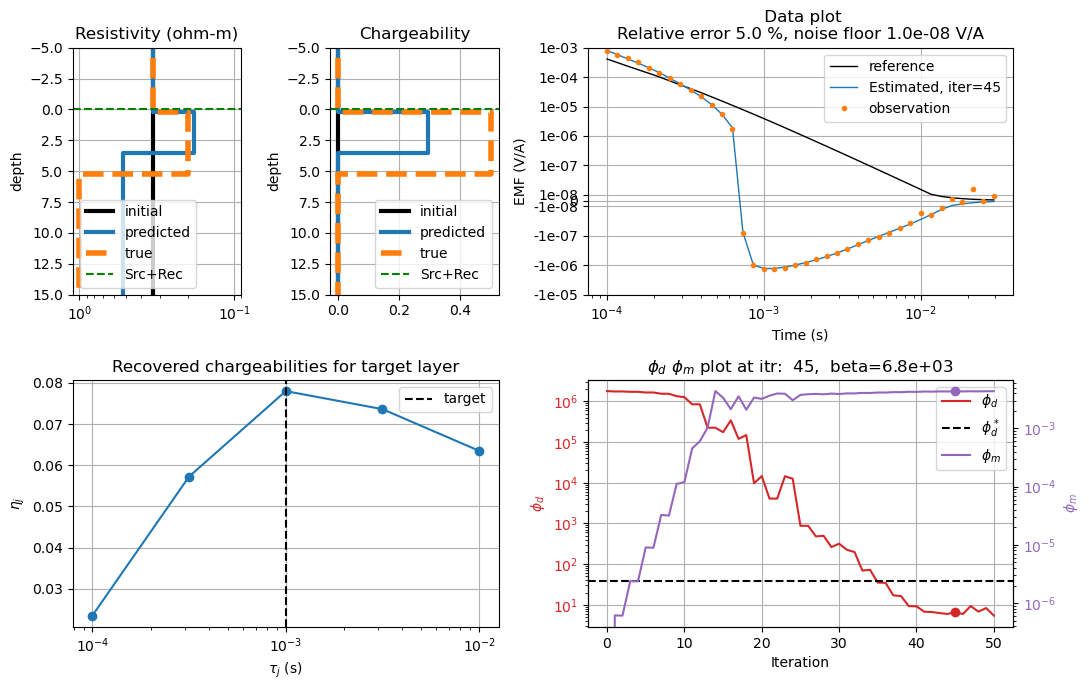

In [80]:
plot_inversion_results_widgets(ind_show=45)
plt.savefig("32_Parametric_Inv_DCS.png",dpi=300)

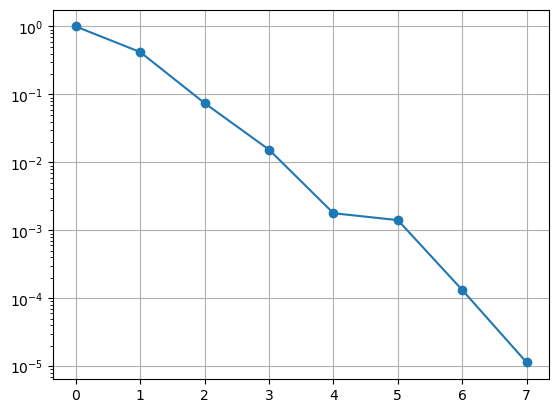

In [48]:
J = opt.J(mpred)
U, s, Vh = np.linalg.svd(J, full_matrices=False)
s_std = s/np.max(s)
plt.semilogy(s_std, marker="o")
plt.grid(True)

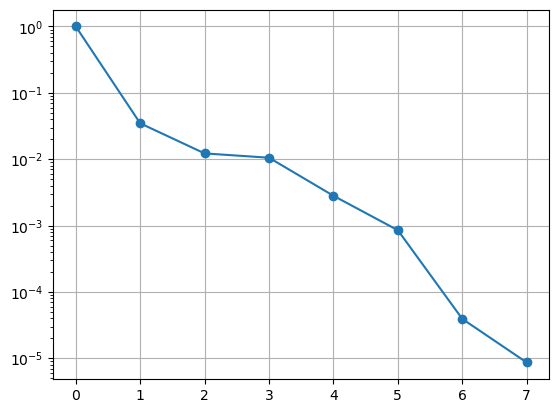

In [49]:
Wd = opt.Wd
U, s, Vh = np.linalg.svd(Wd@J, full_matrices=False)
s_std = s/np.max(s)
plt.semilogy(s_std, marker="o")
plt.grid(True)

In [68]:
windows_cen-rmp_time

array([0.0001    , 0.00011659, 0.00013594, 0.00015849, 0.00018478,
       0.00021544, 0.00025119, 0.00029286, 0.00034145, 0.00039811,
       0.00046416, 0.00054117, 0.00063096, 0.00073564, 0.0008577 ,
       0.001     , 0.00116591, 0.00135936, 0.00158489, 0.00184785,
       0.00215443, 0.00251189, 0.00292864, 0.00341455, 0.00398107,
       0.00464159, 0.0054117 , 0.00630957, 0.00735642, 0.00857696,
       0.01      , 0.01165914, 0.01359356, 0.01584893, 0.0184785 ,
       0.02154435, 0.02511886, 0.02928645])

# Animation

In [81]:
dpi=300

In [82]:
def save_all_fields_images(index_list, output_folder='images'):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for ind_save in index_list:
        # Create a new figure and axes for each time index
        plot_inversion_results(ind_show=ind_save)

        # Create a filename with zero padding (e.g., 001.png, 002.png)
        filename = f'{ind_save:03d}.png'
        # Save the figure to the output folder
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0.1)
        
        # Close the figure to avoid display issues and free up memory
        plt.close(fig)

C:\Users\81805\AppData\Local\Temp\ipykernel_33128\895309102.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(11, 7))


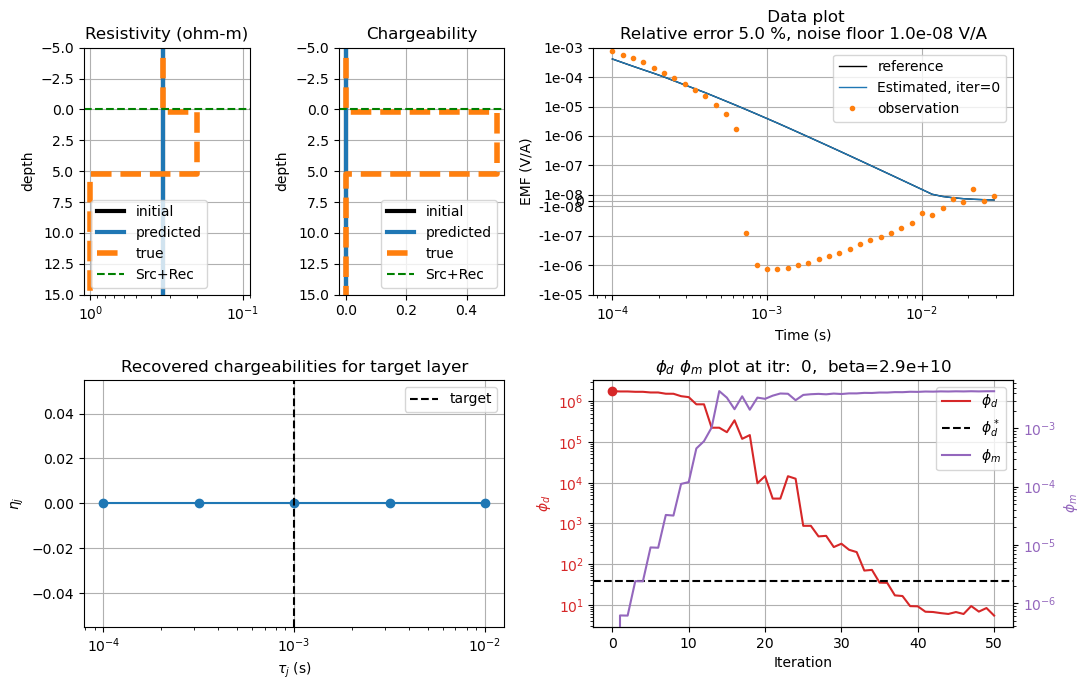

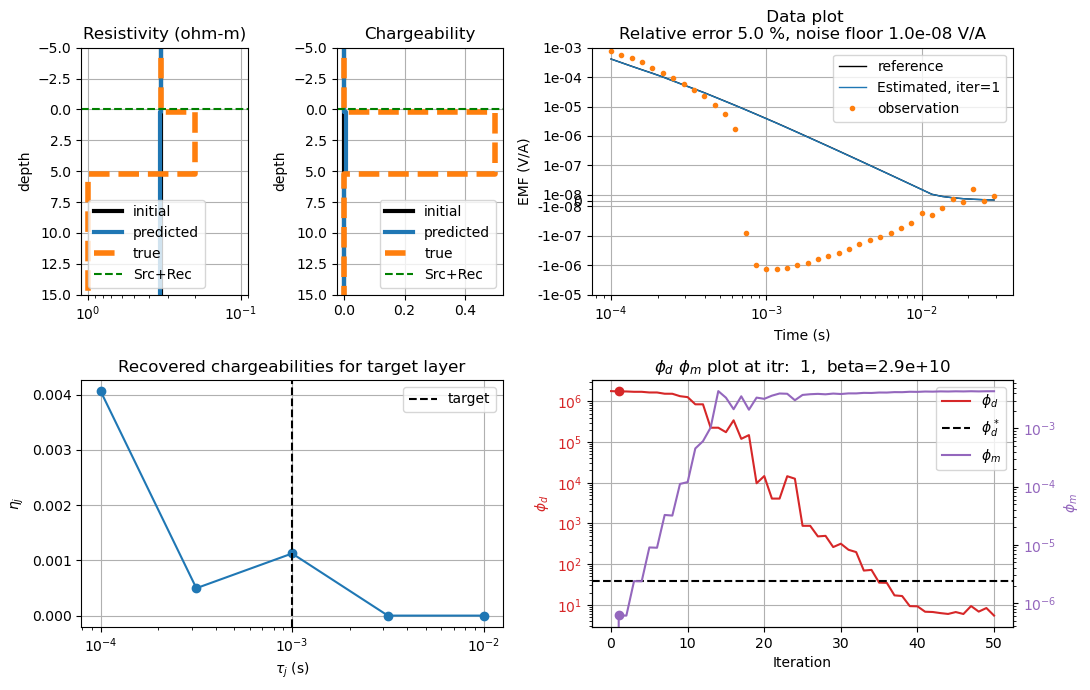

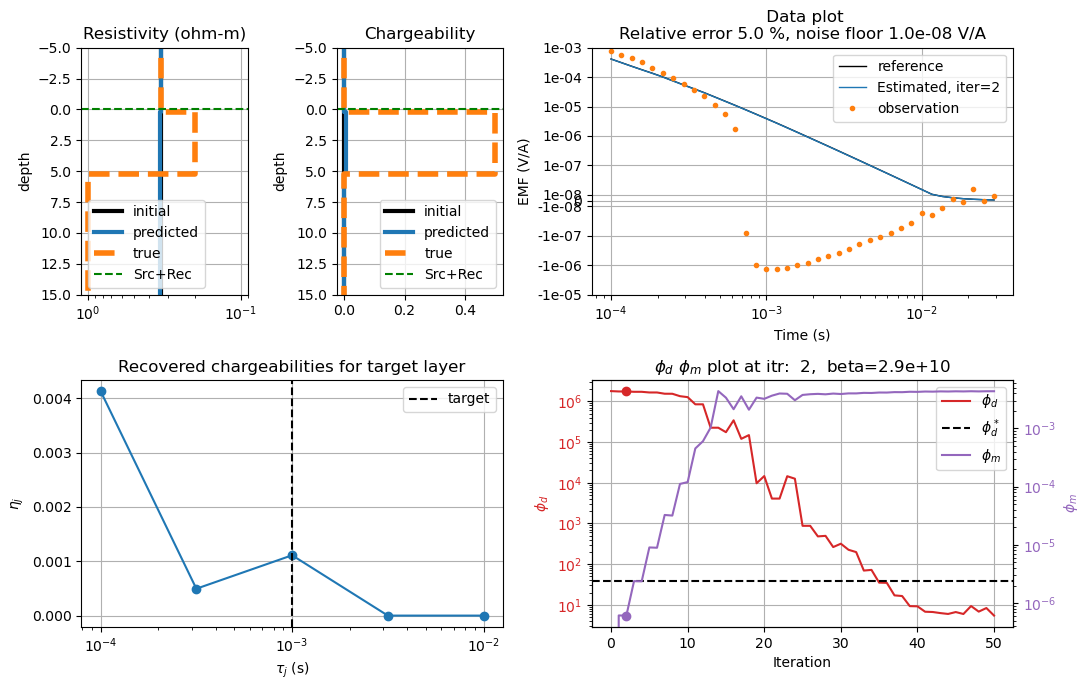

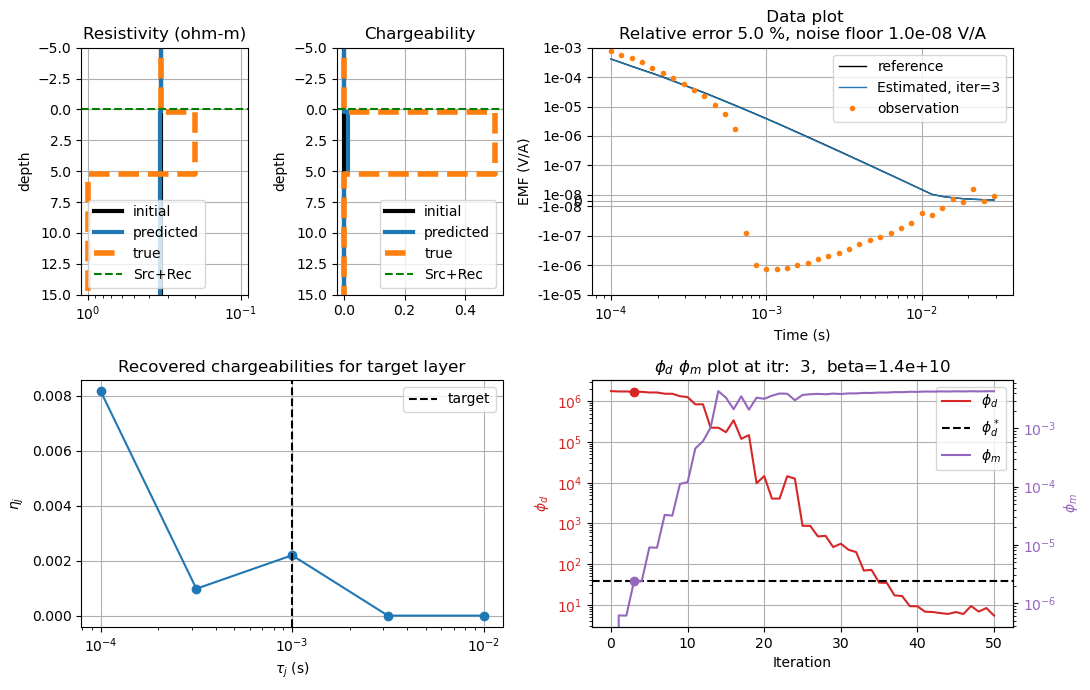

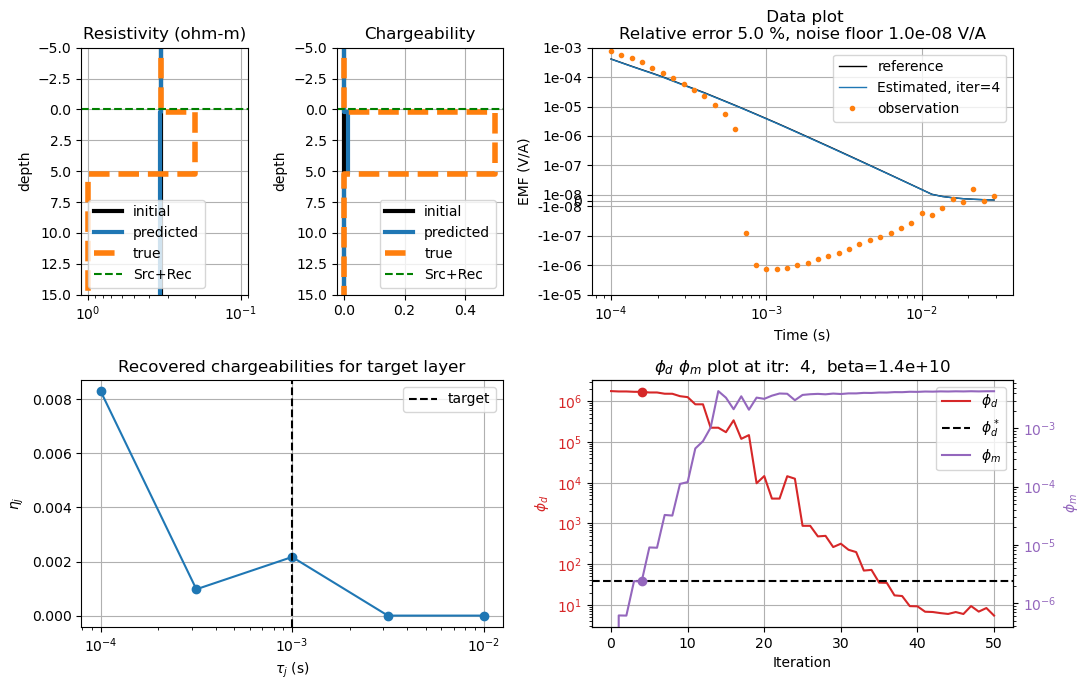

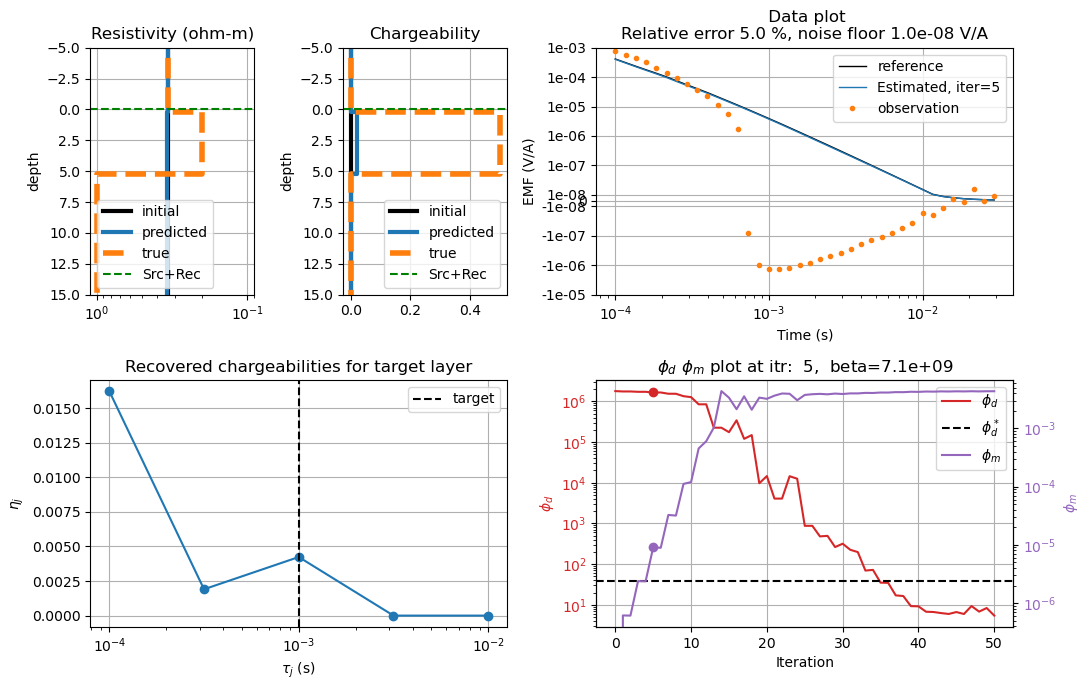

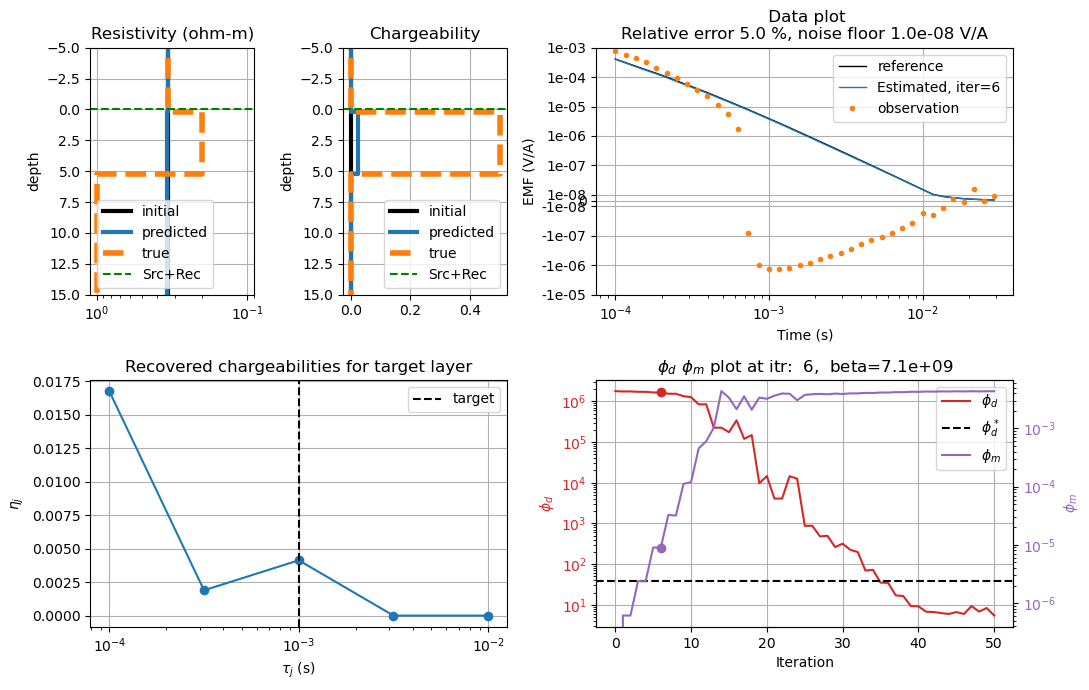

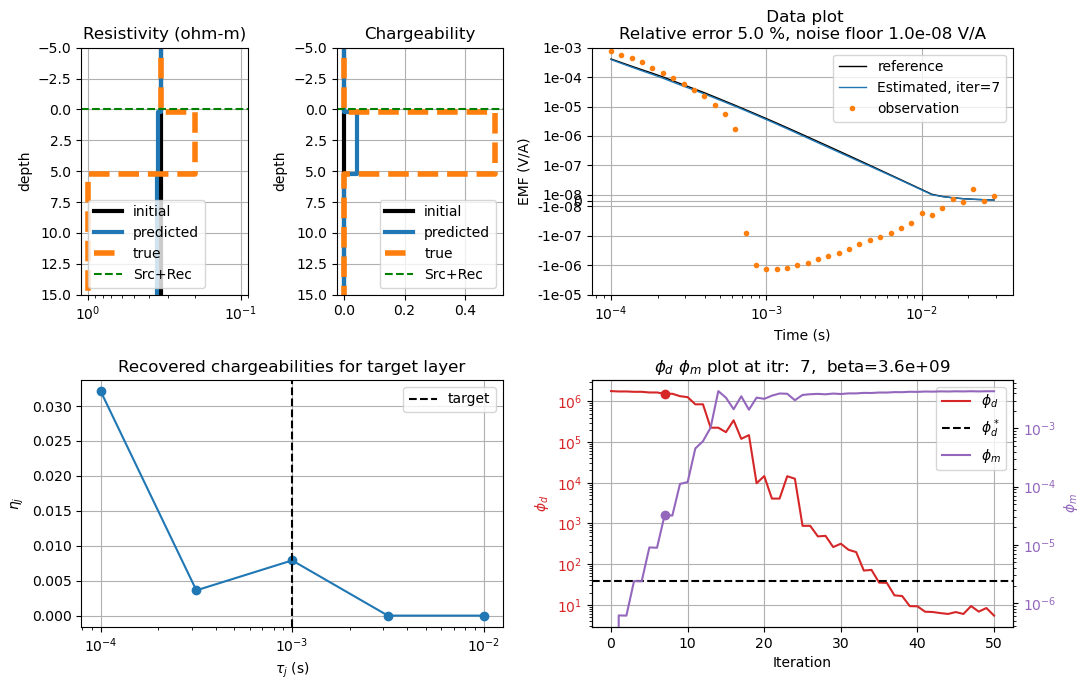

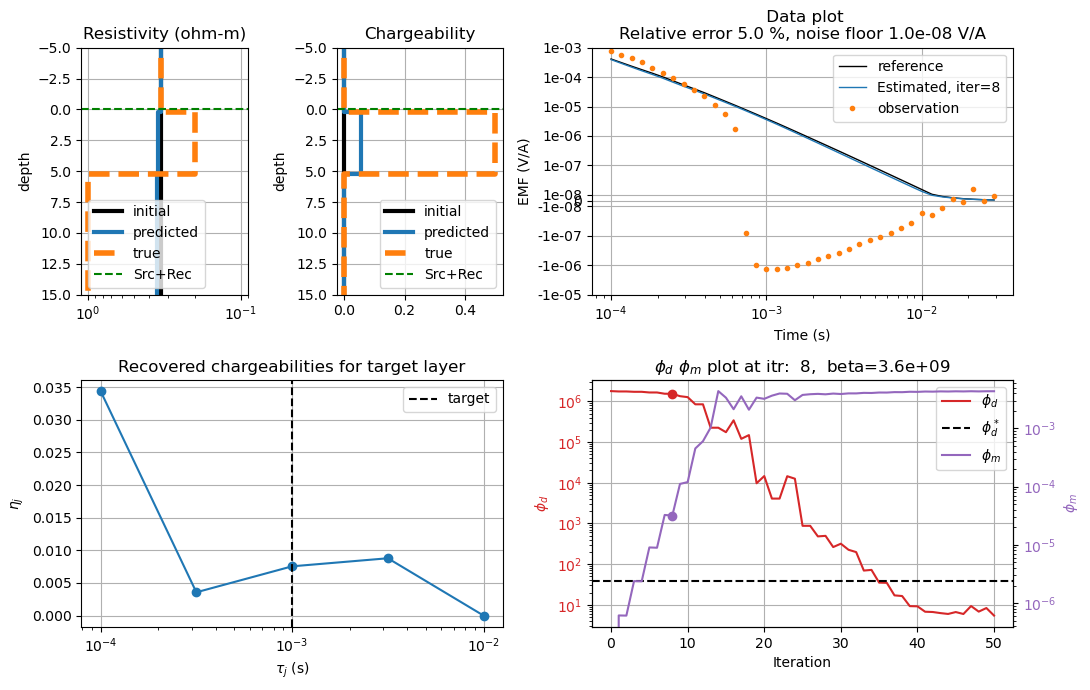

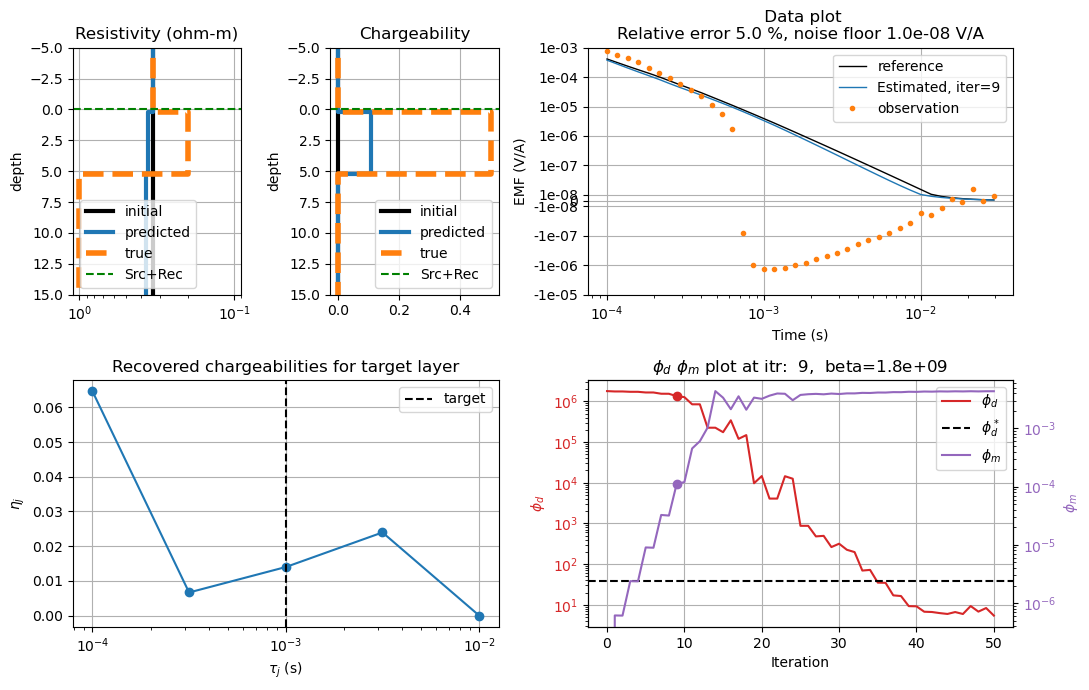

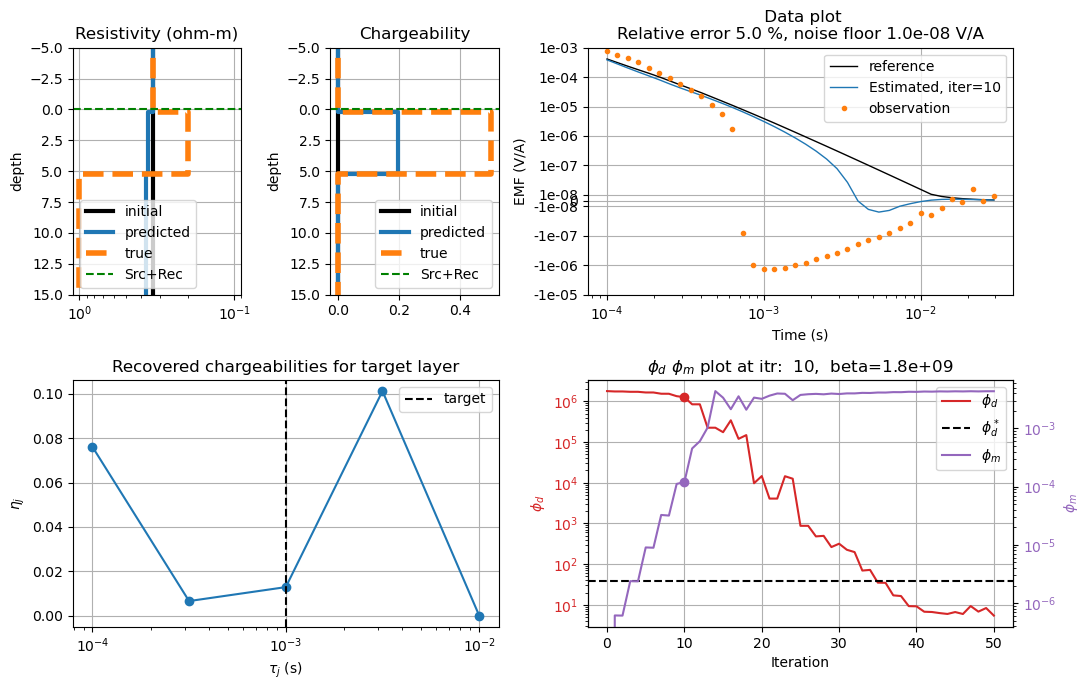

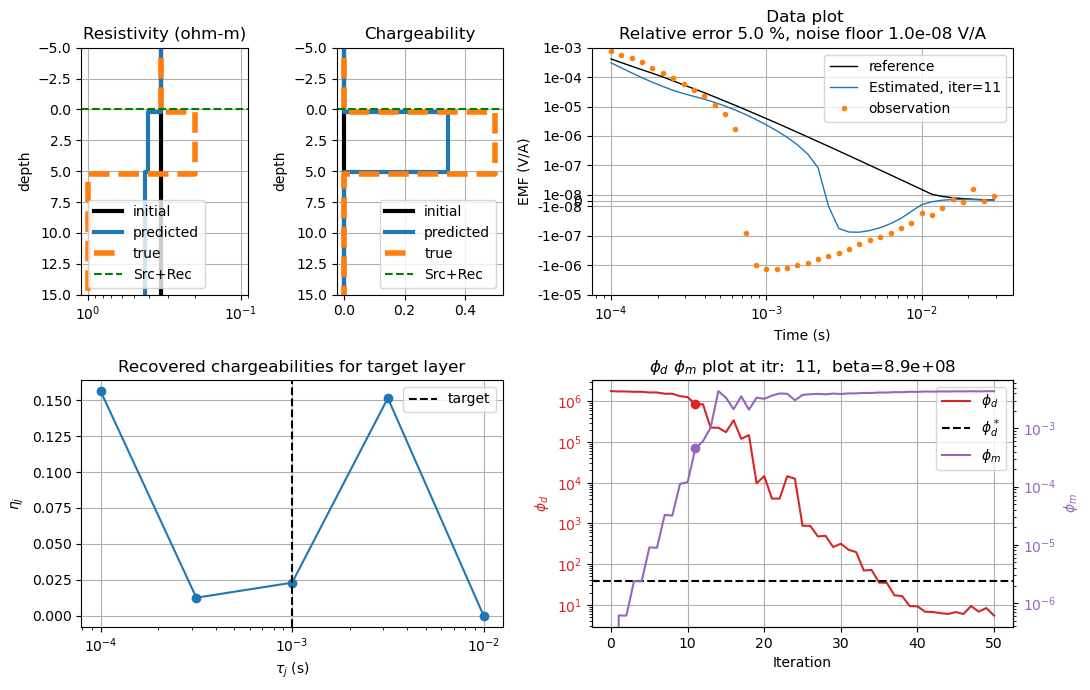

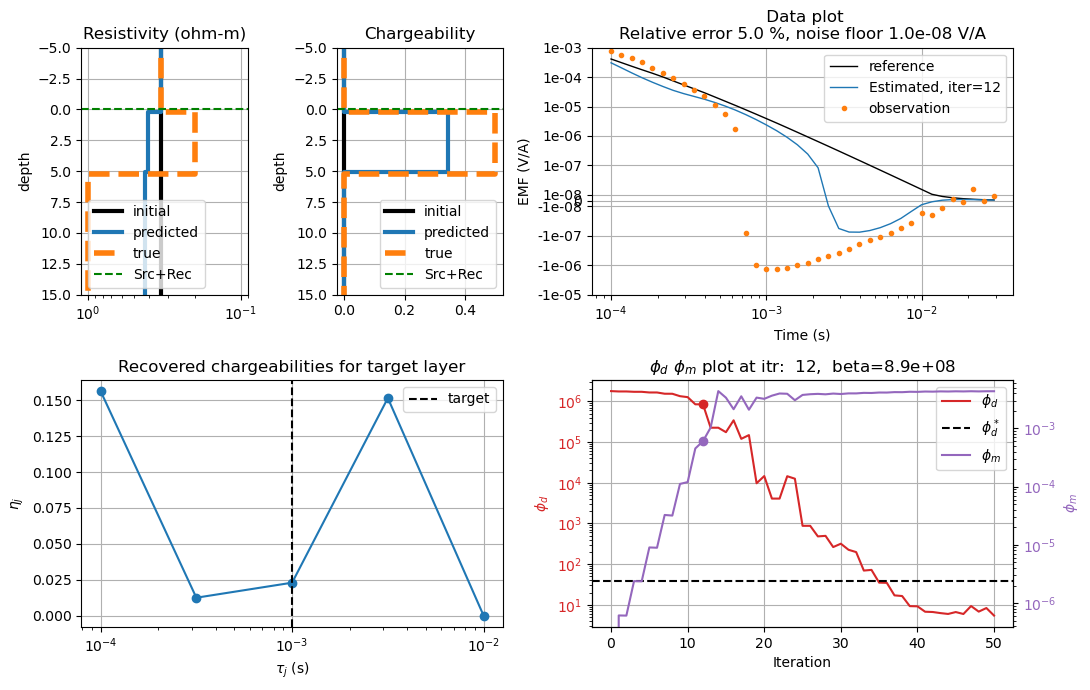

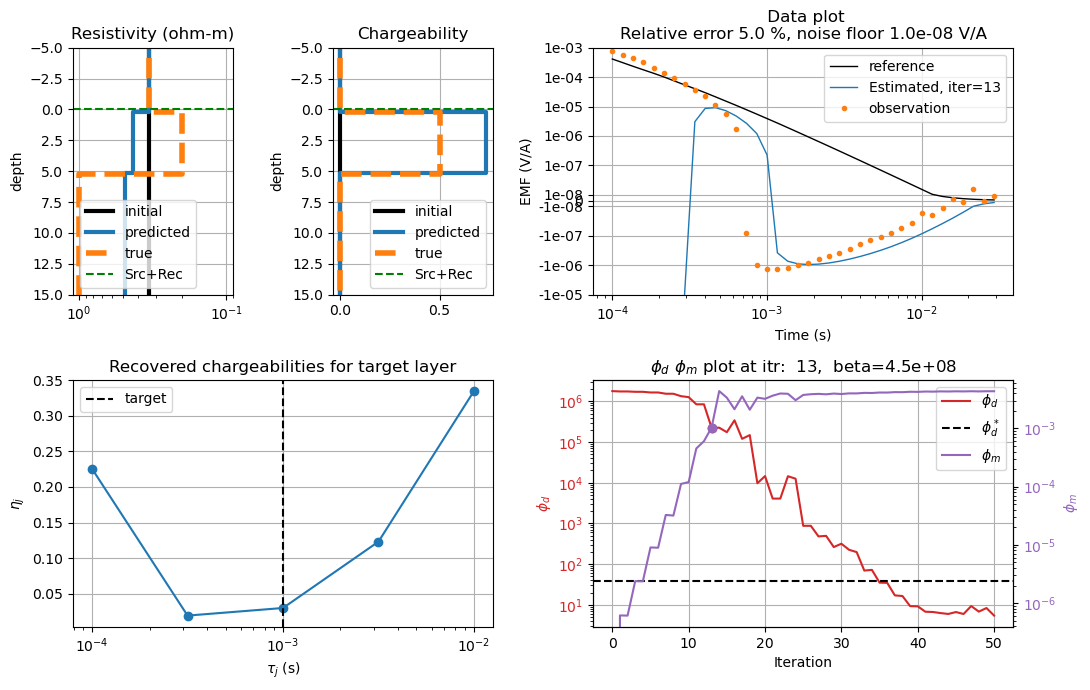

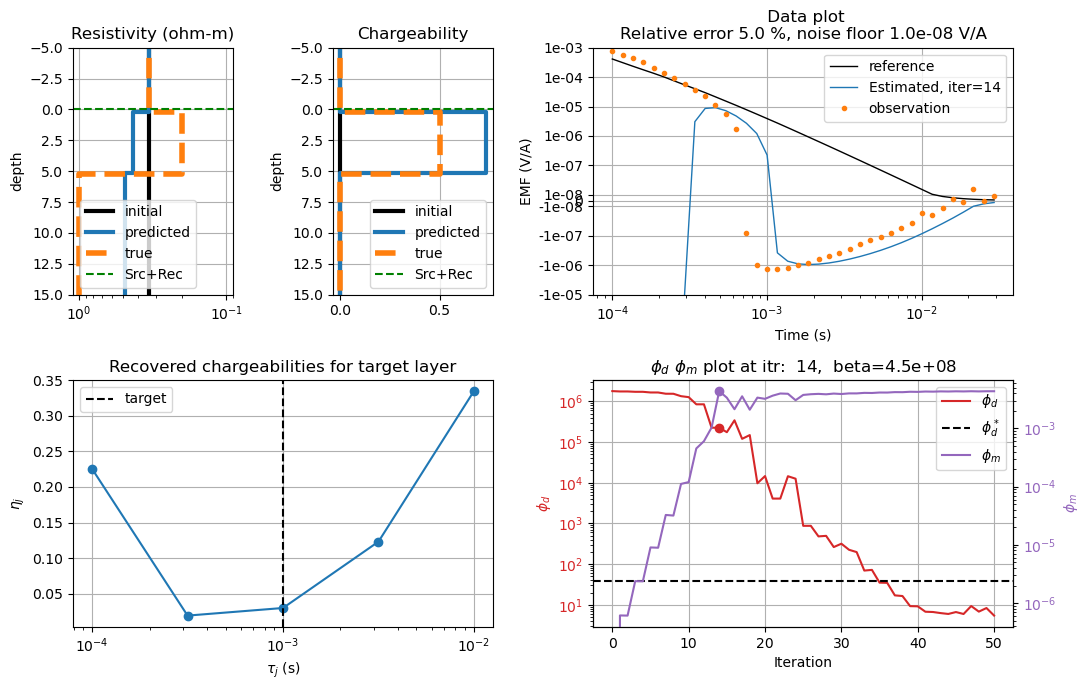

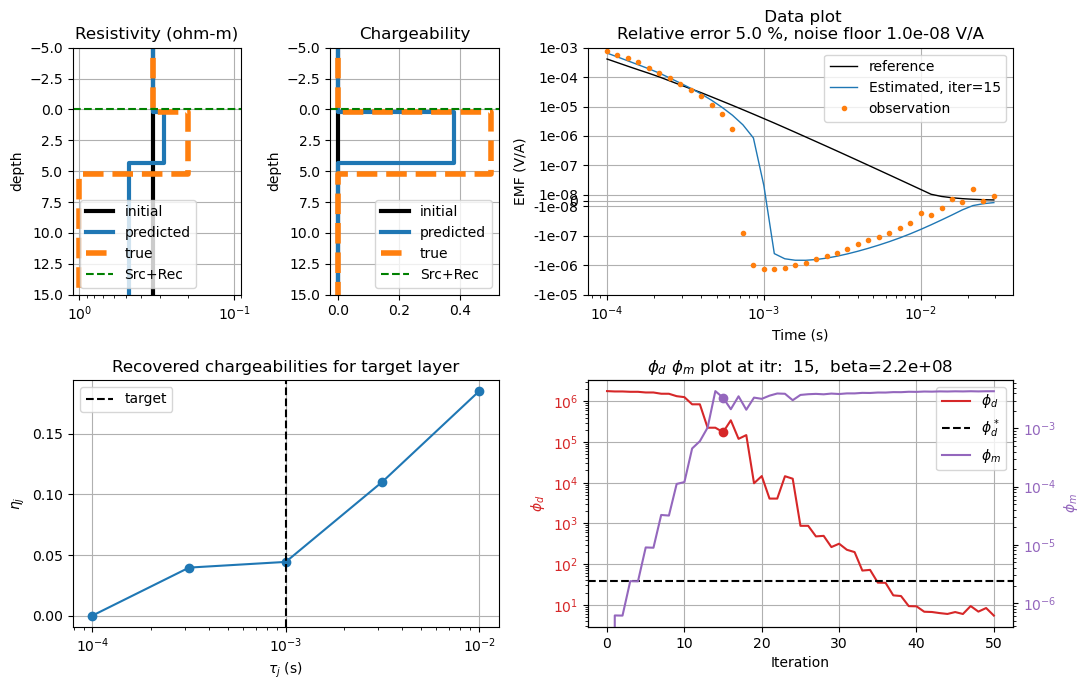

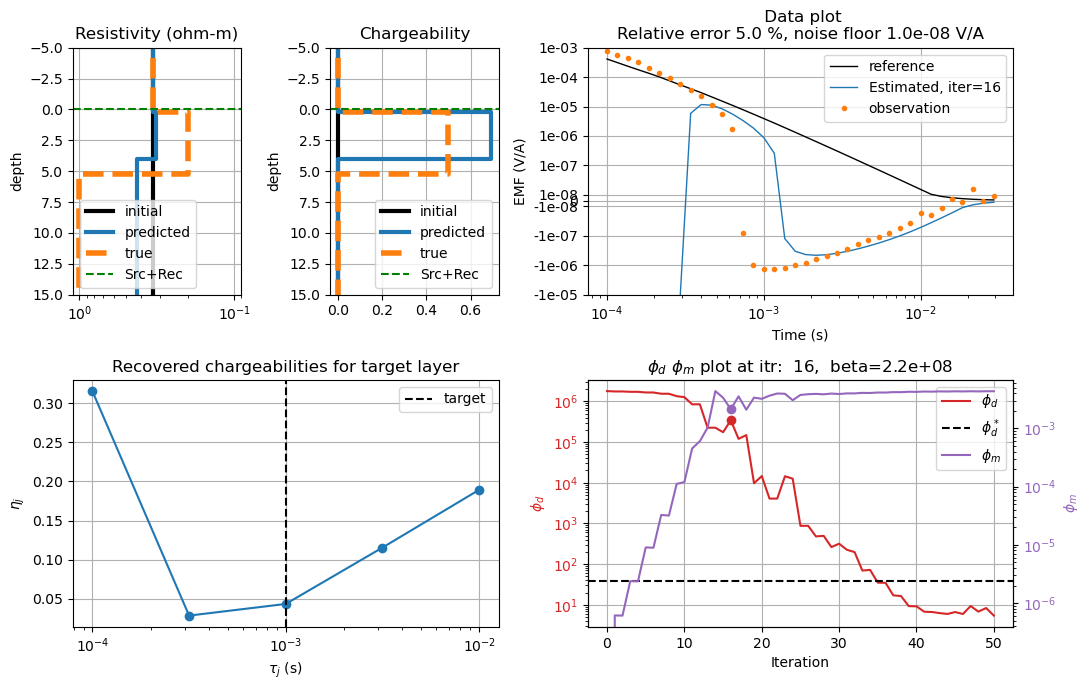

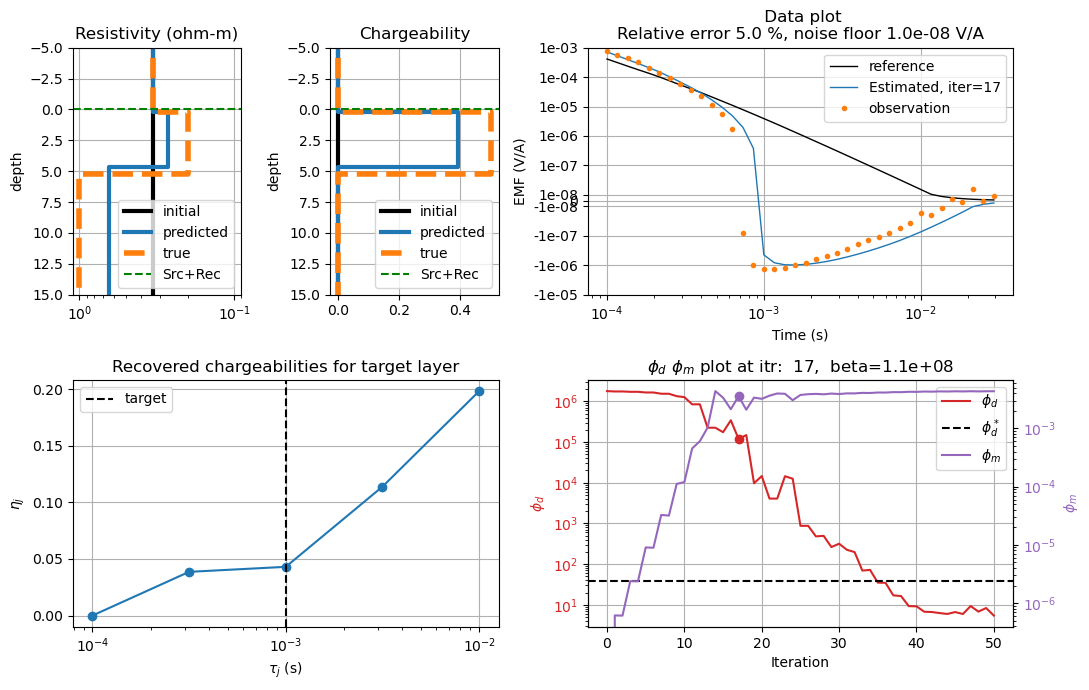

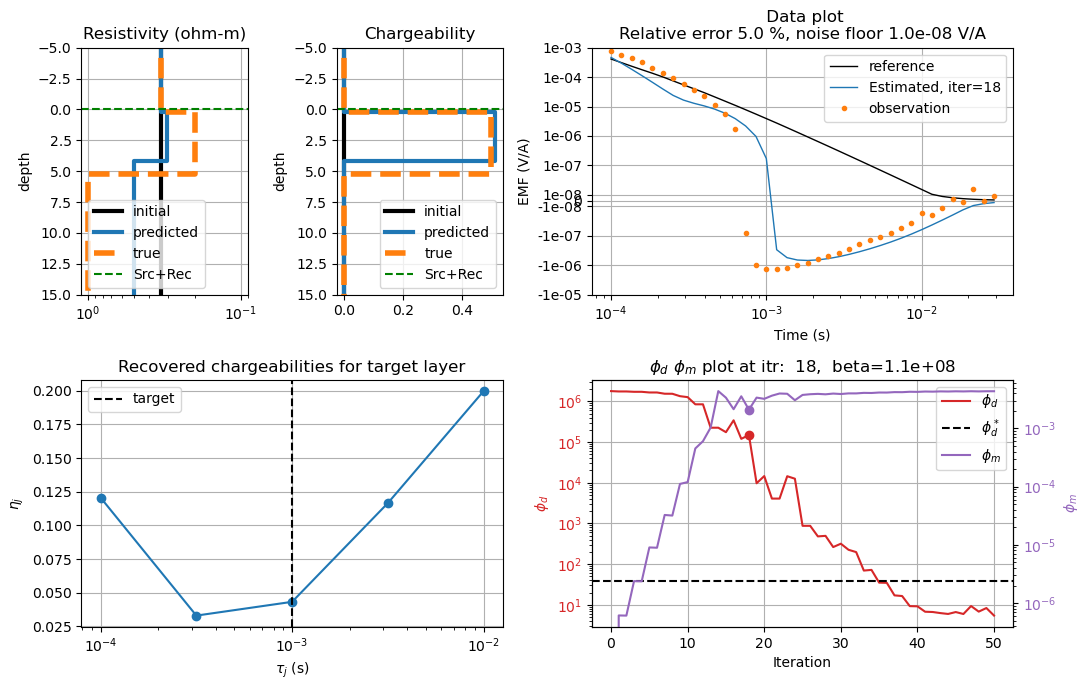

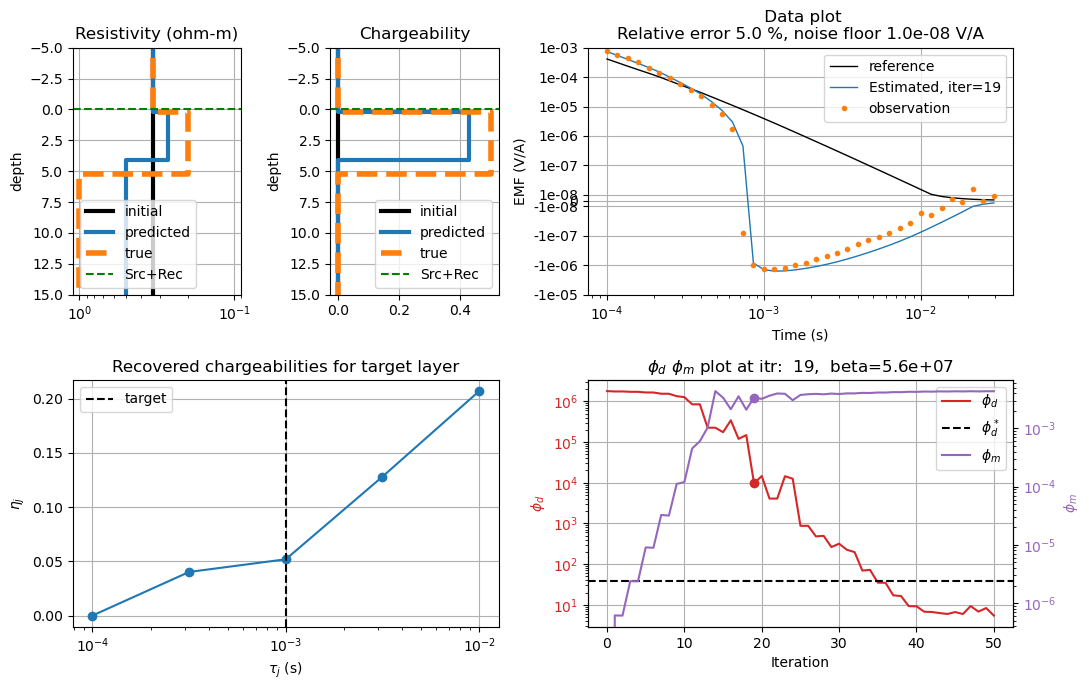

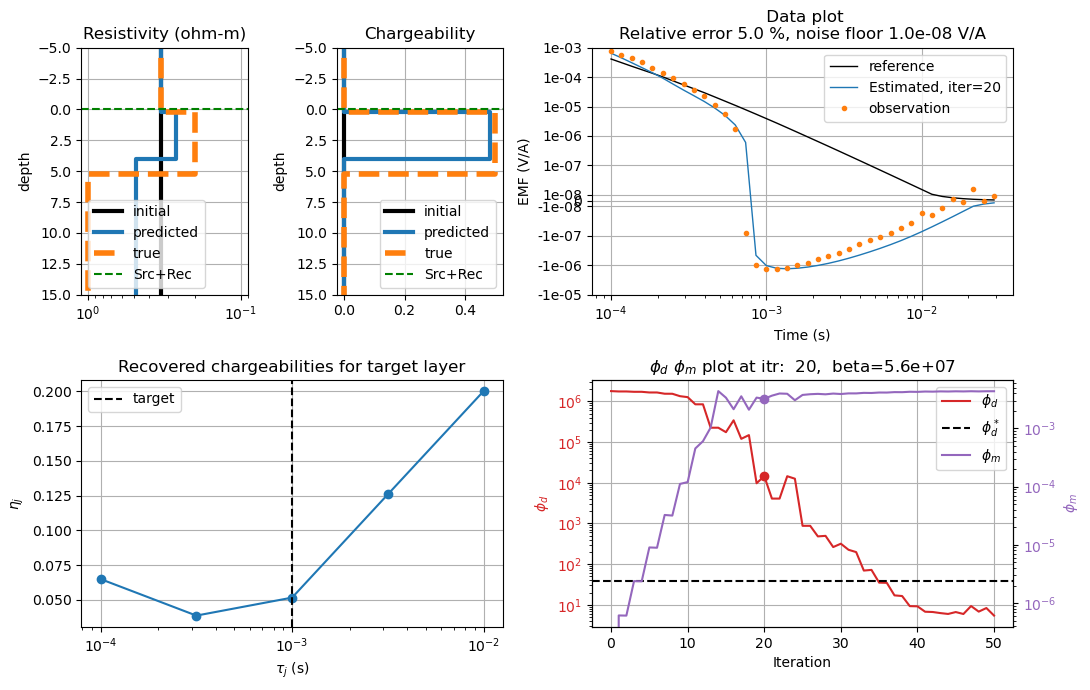

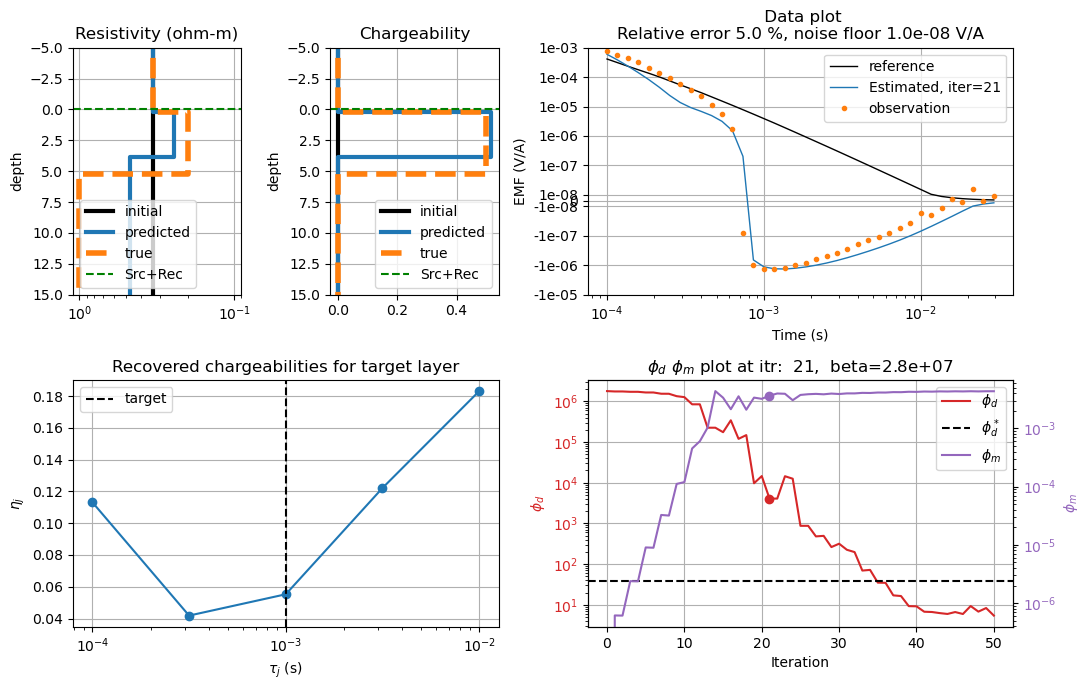

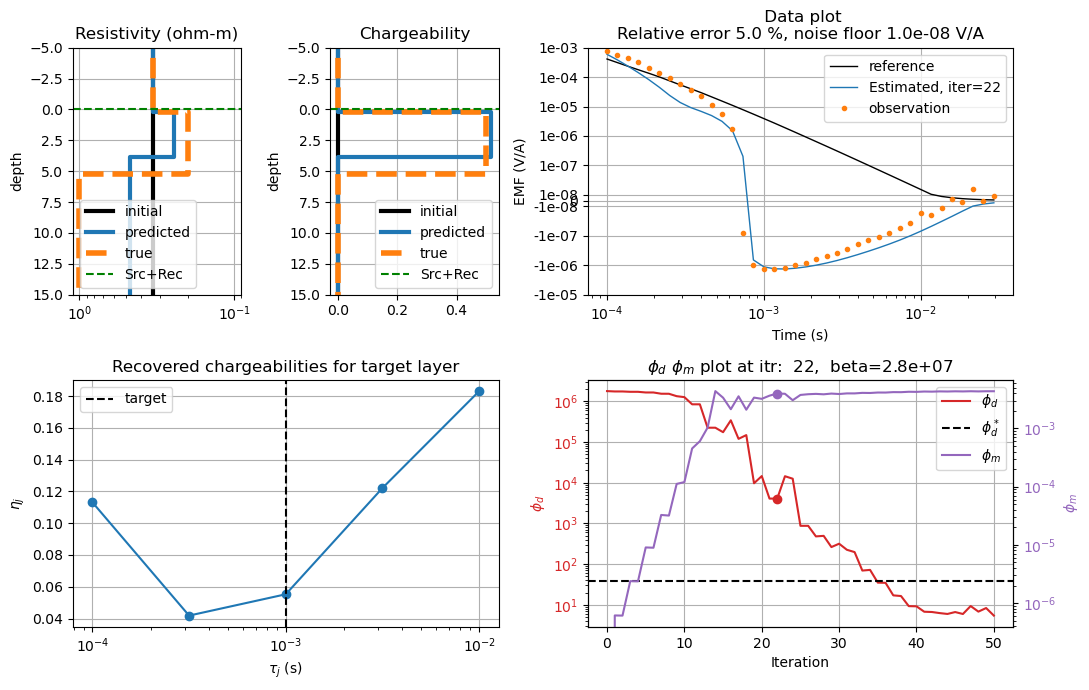

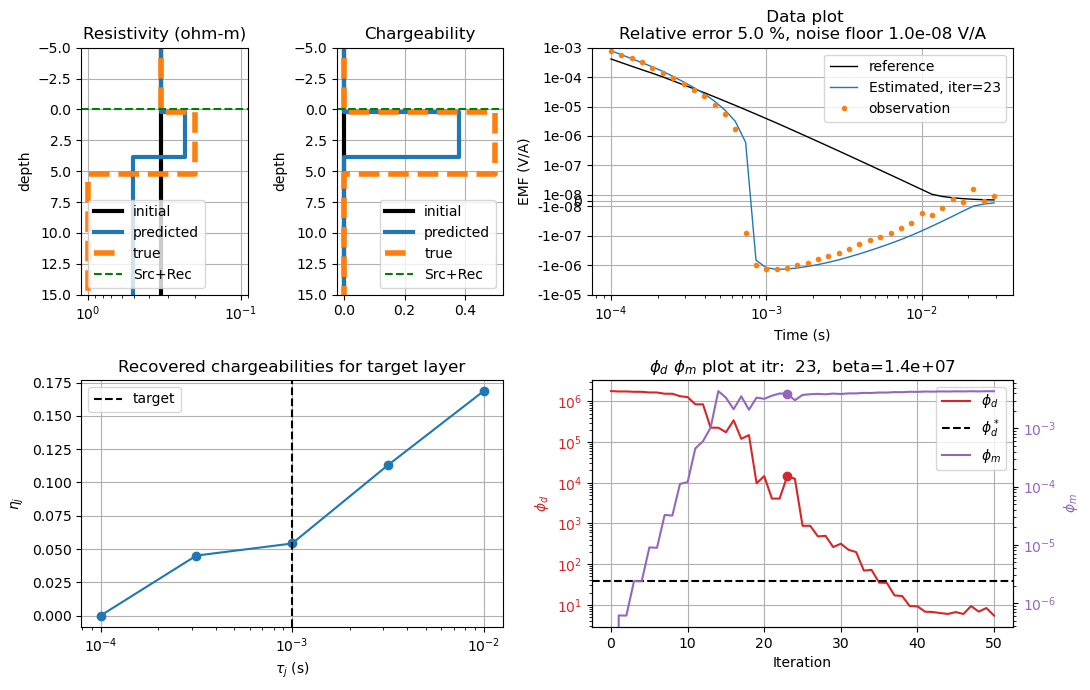

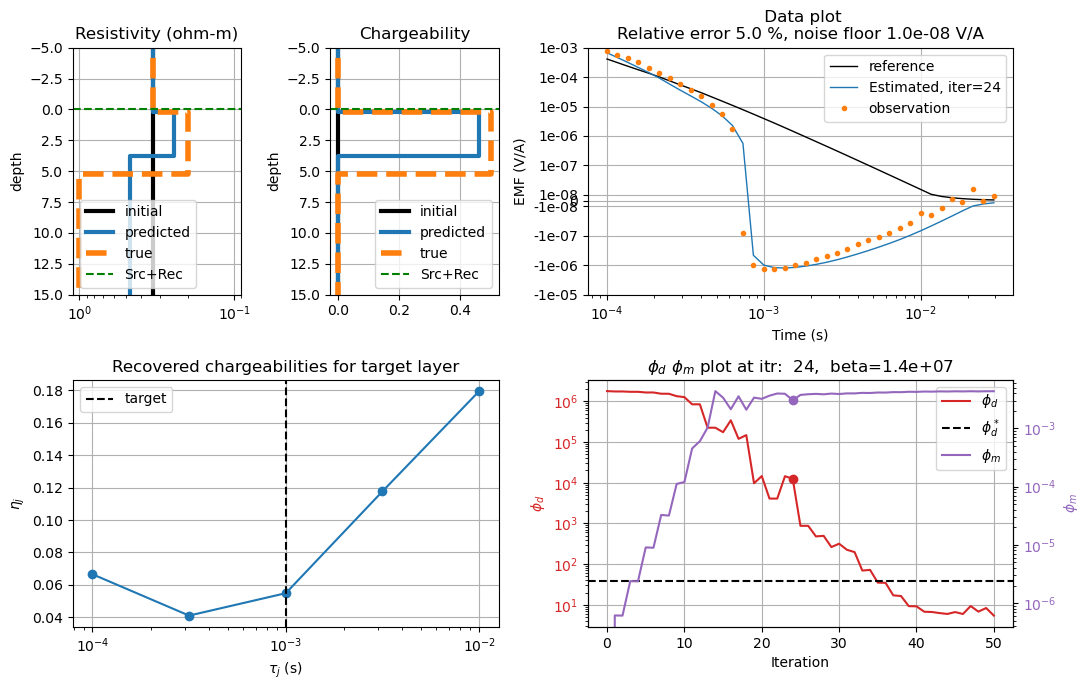

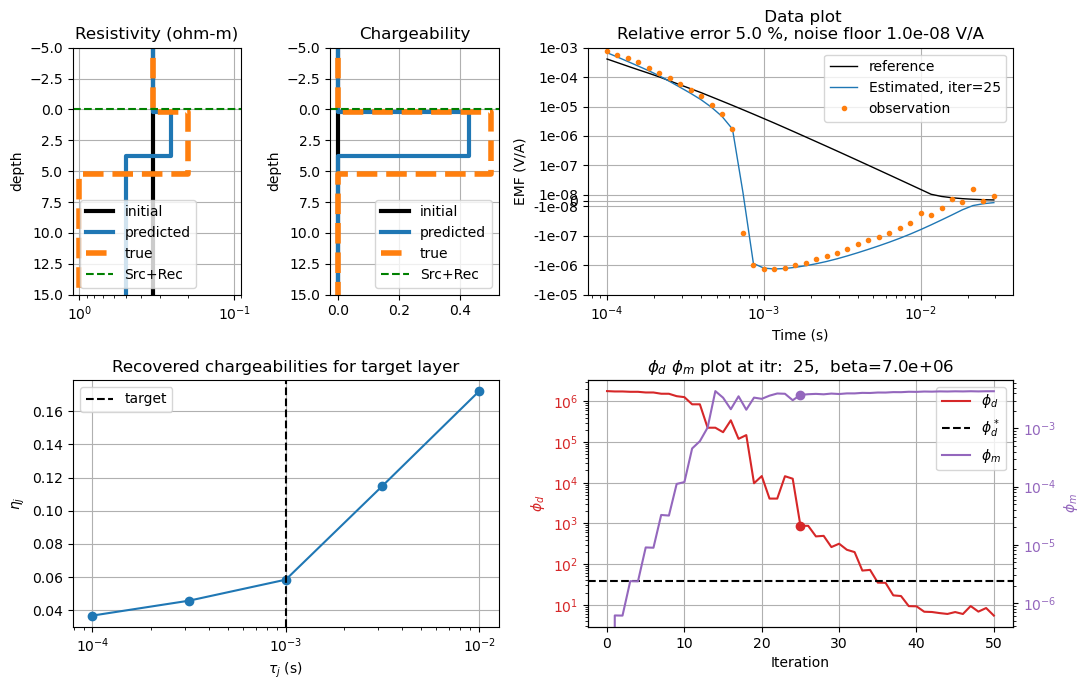

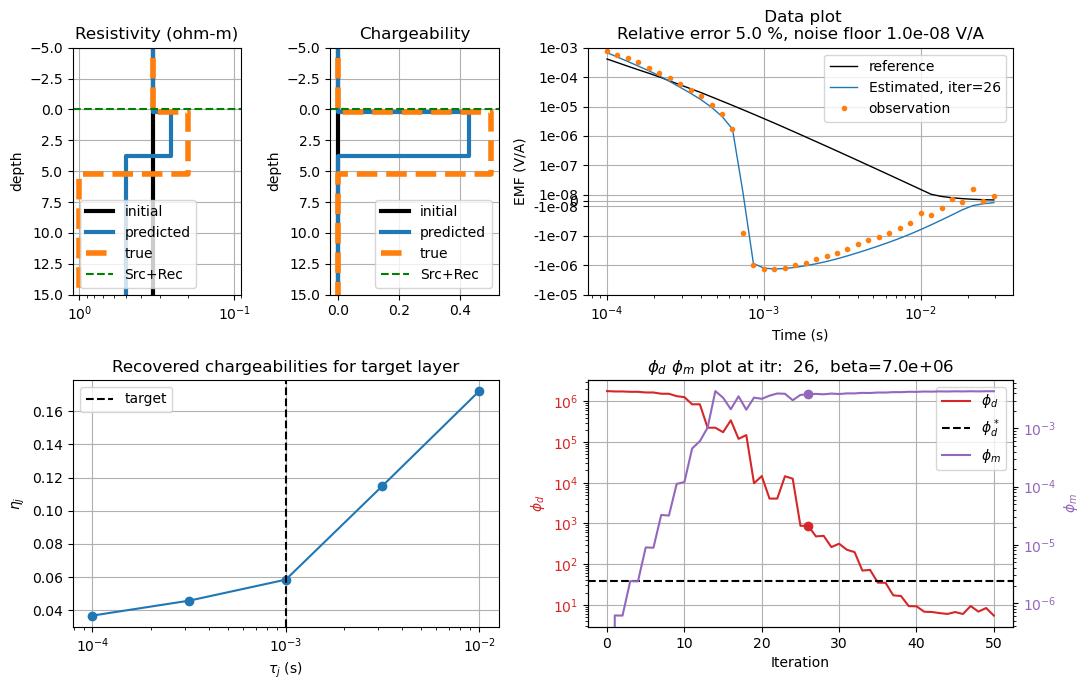

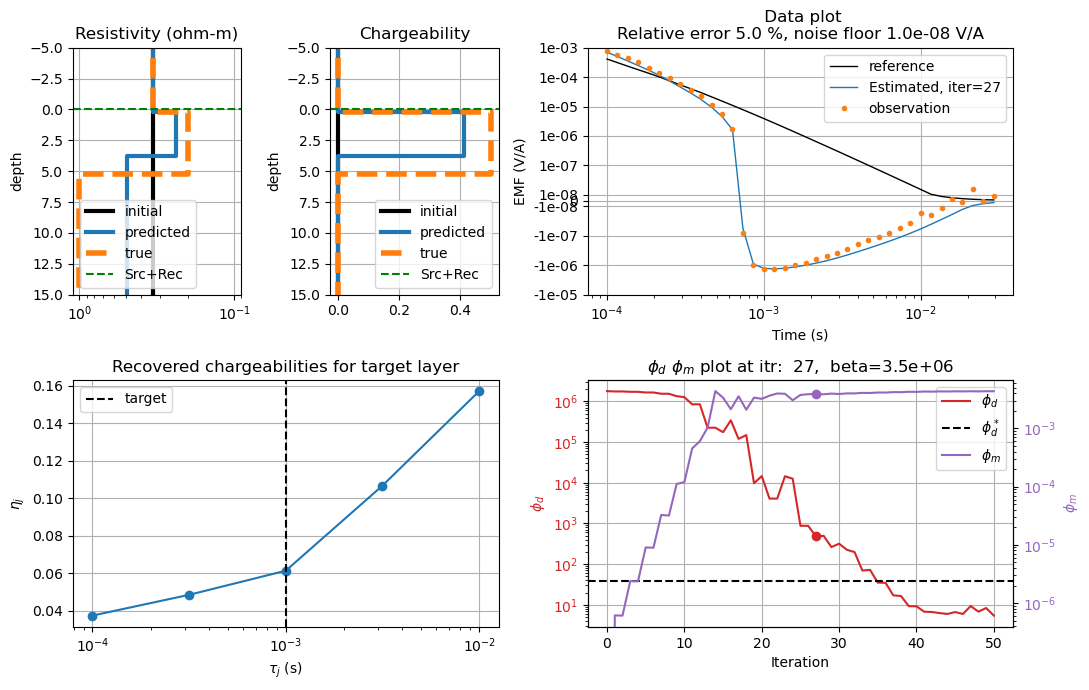

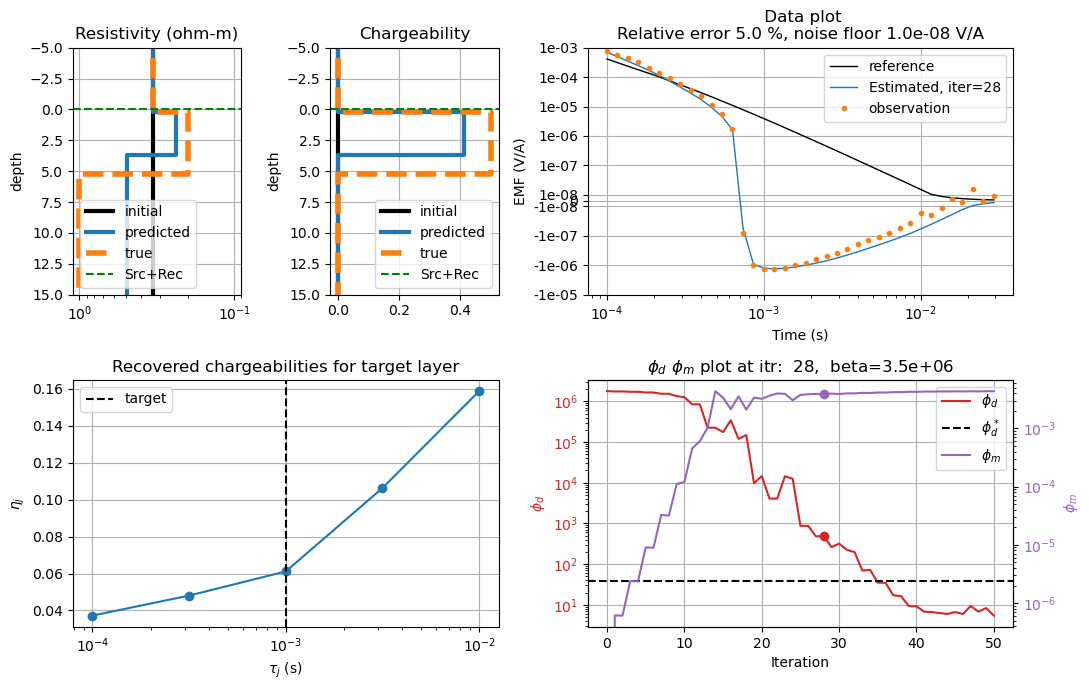

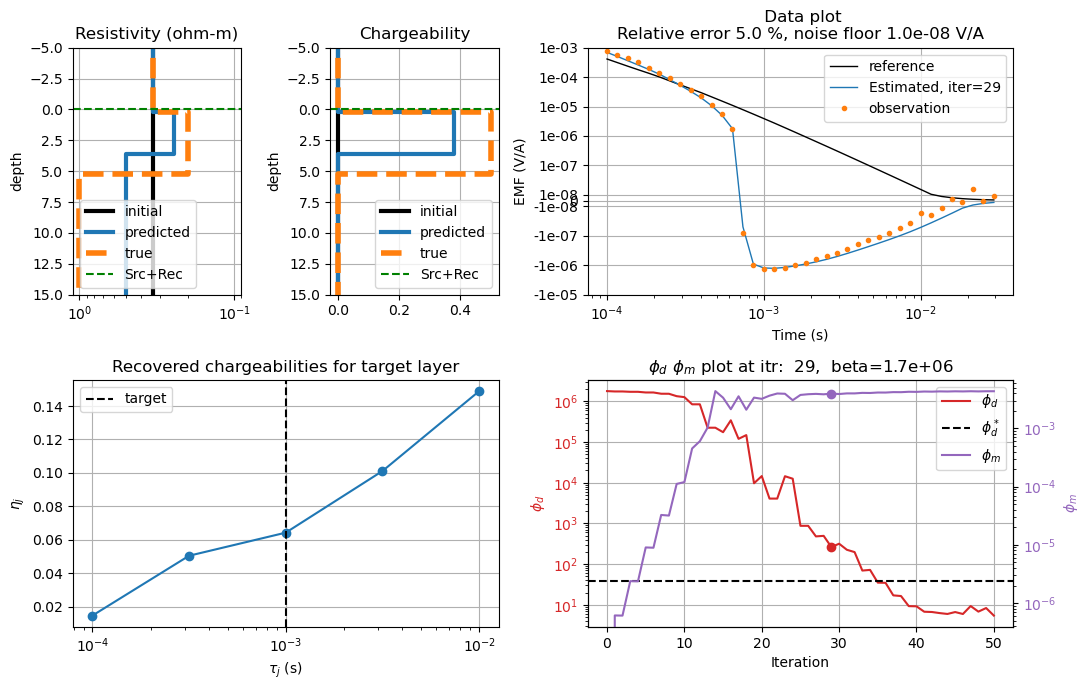

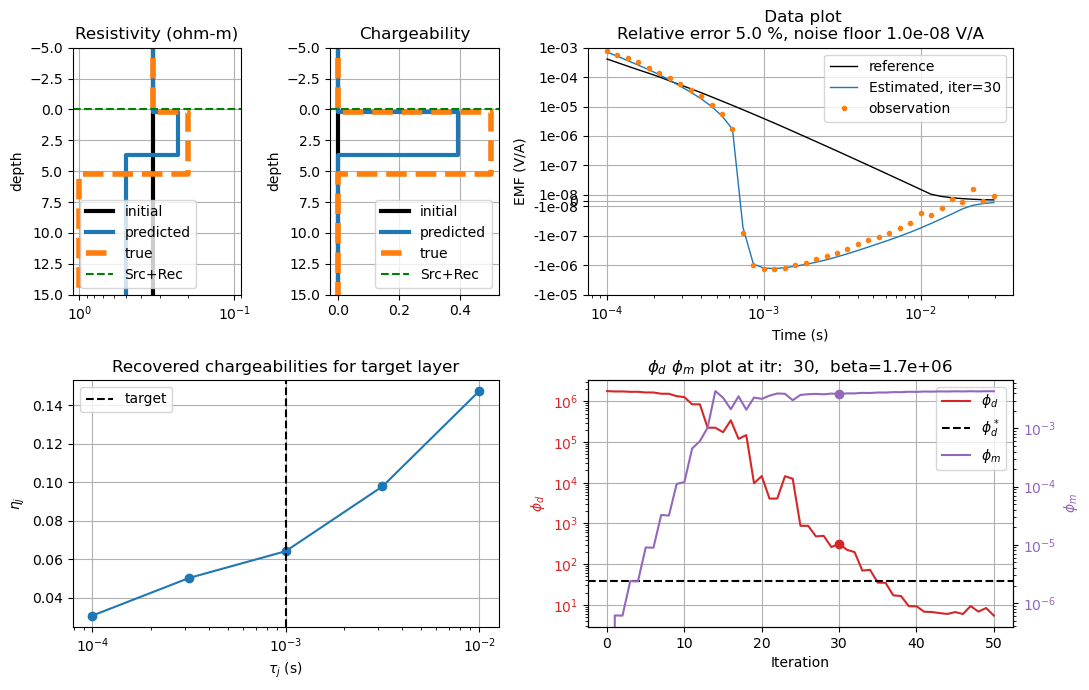

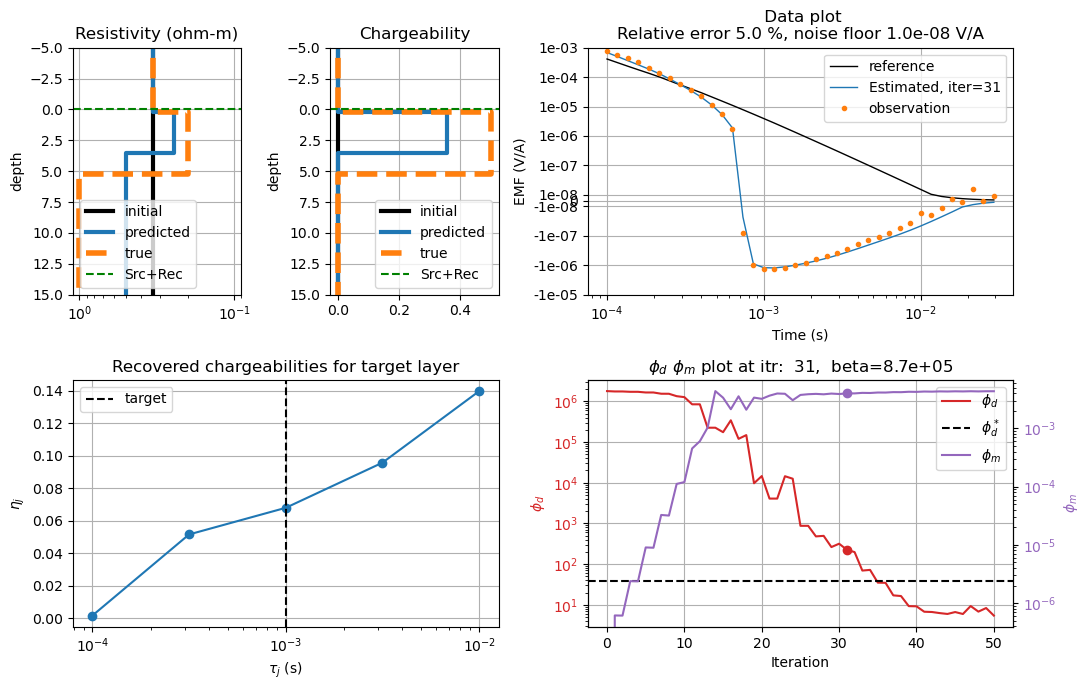

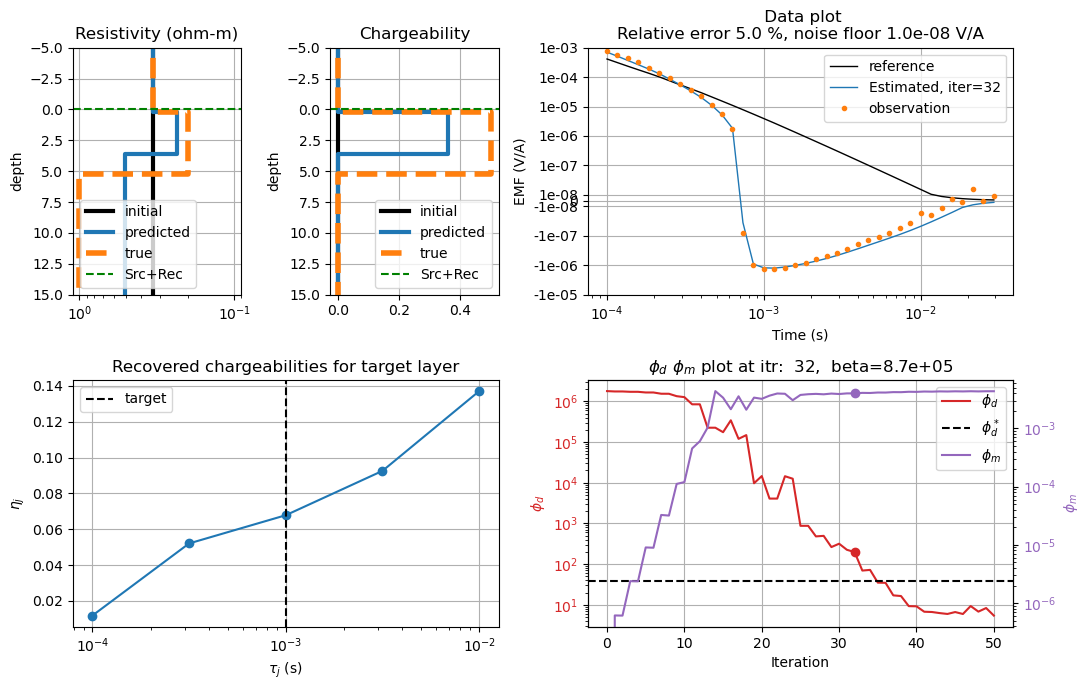

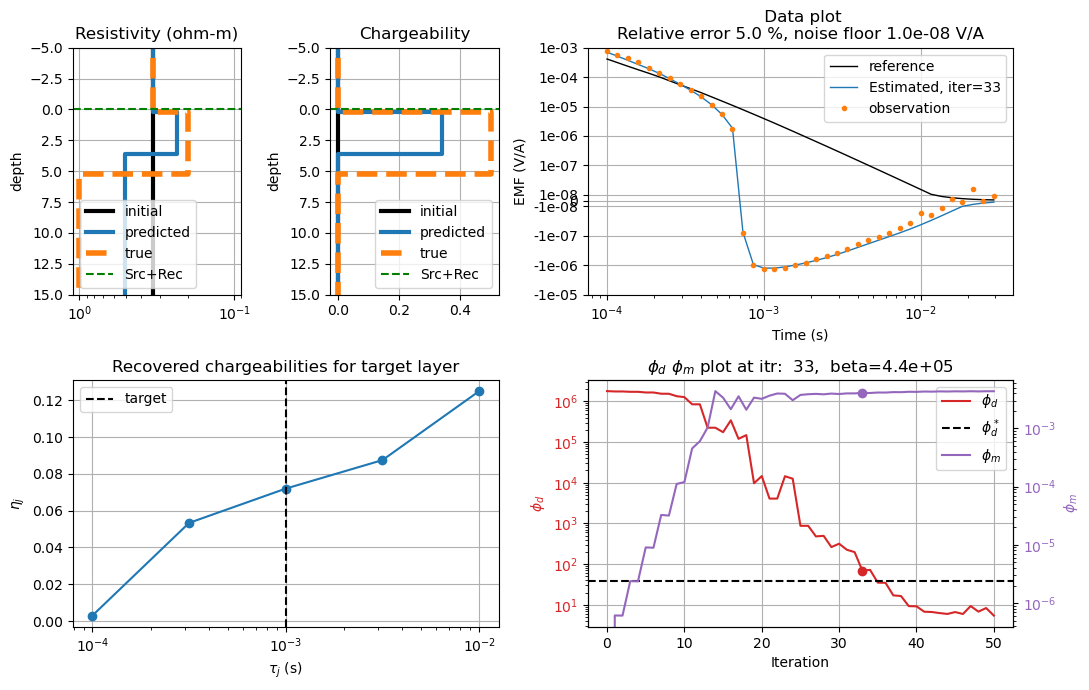

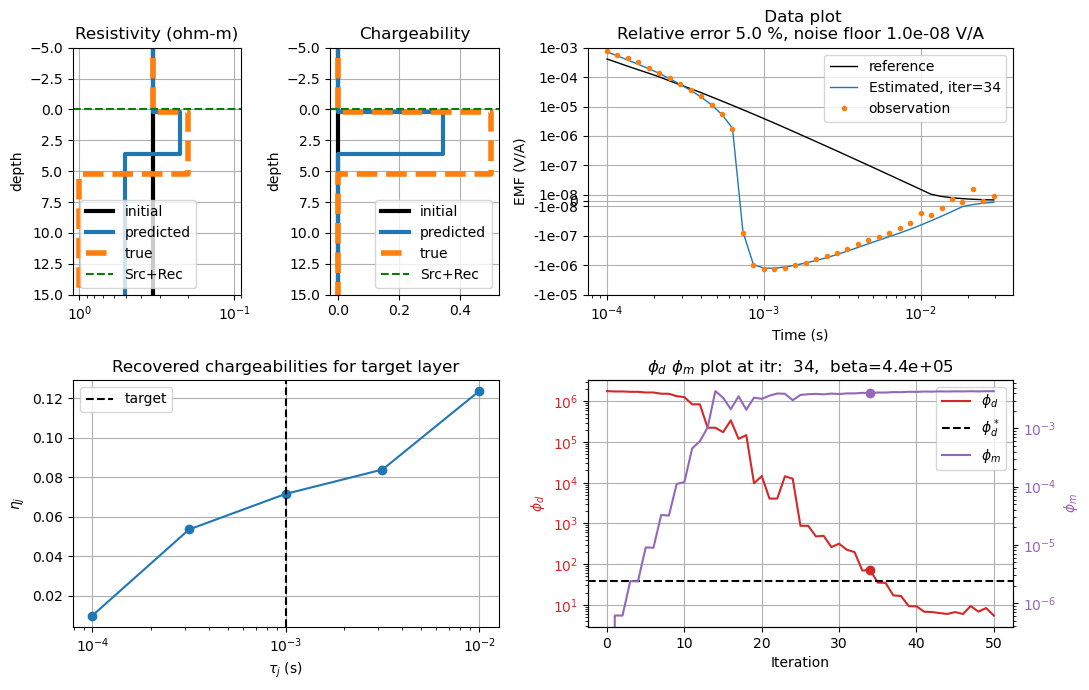

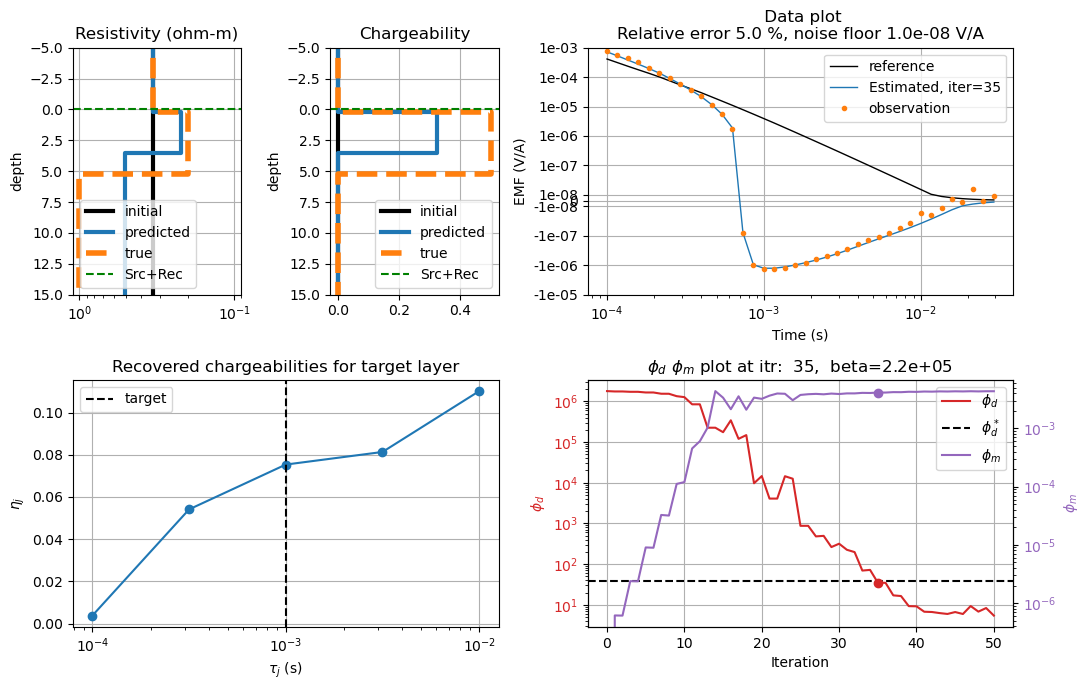

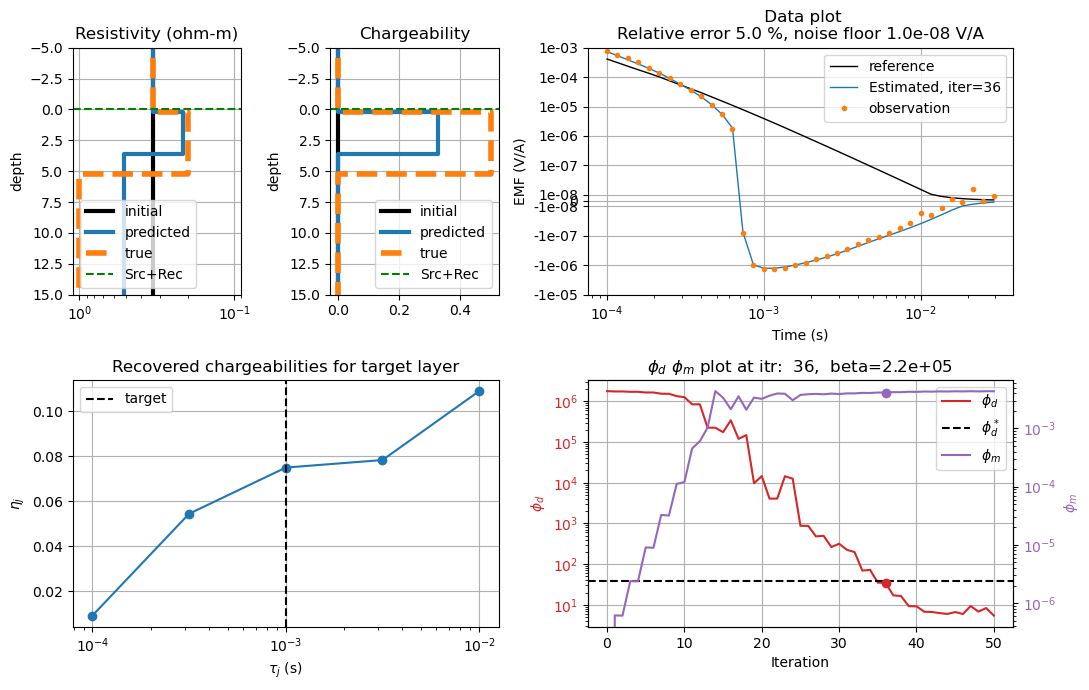

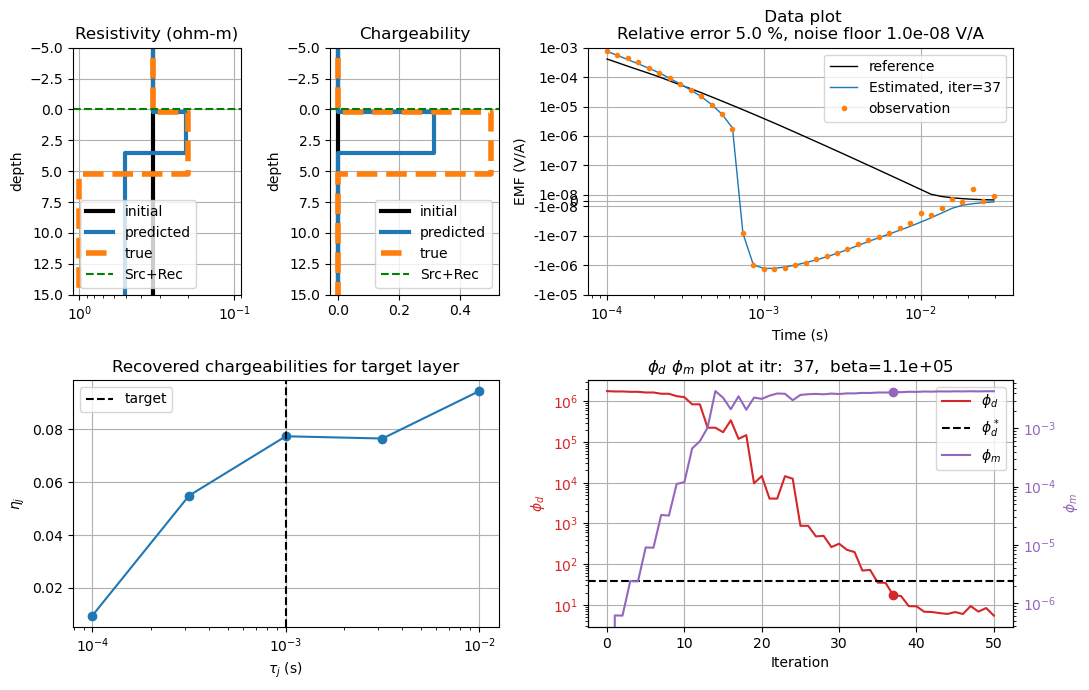

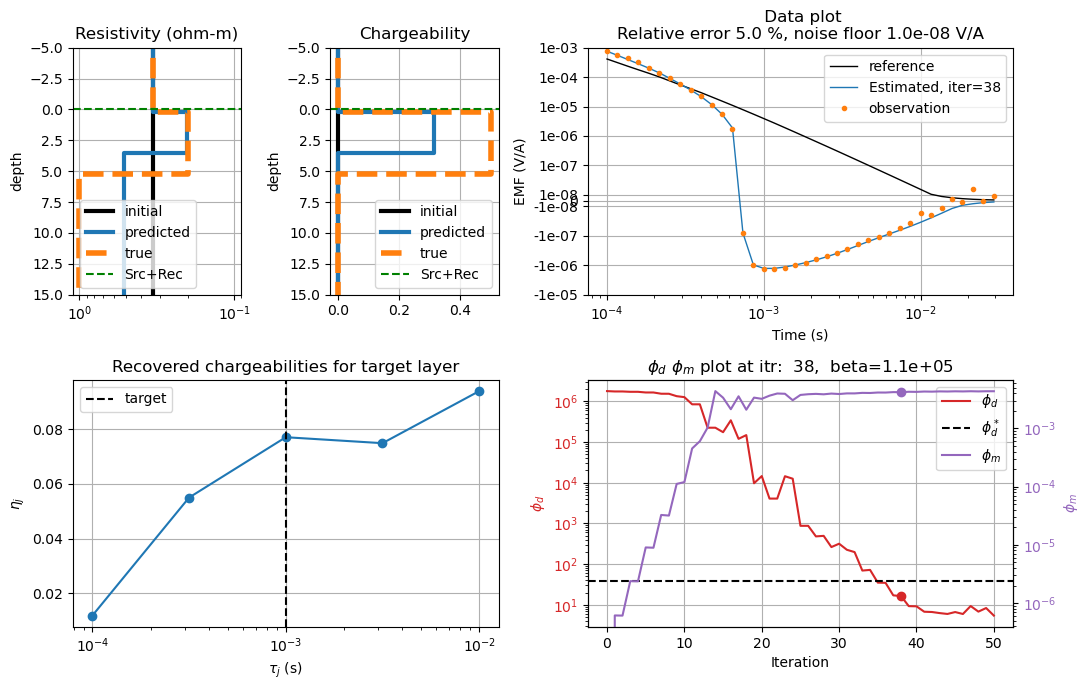

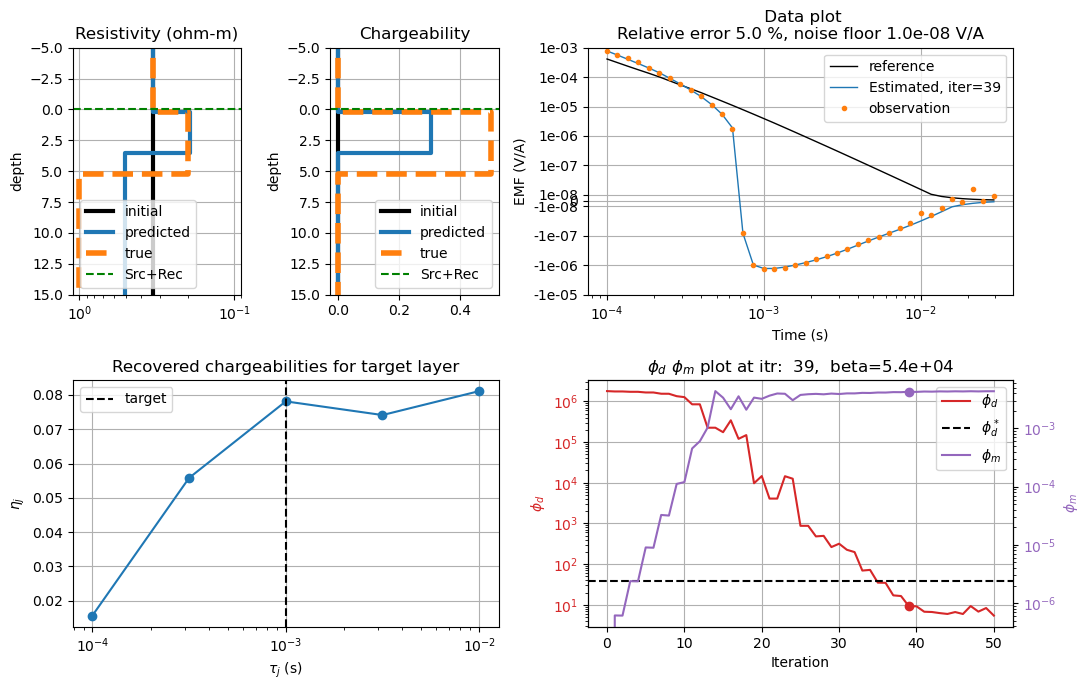

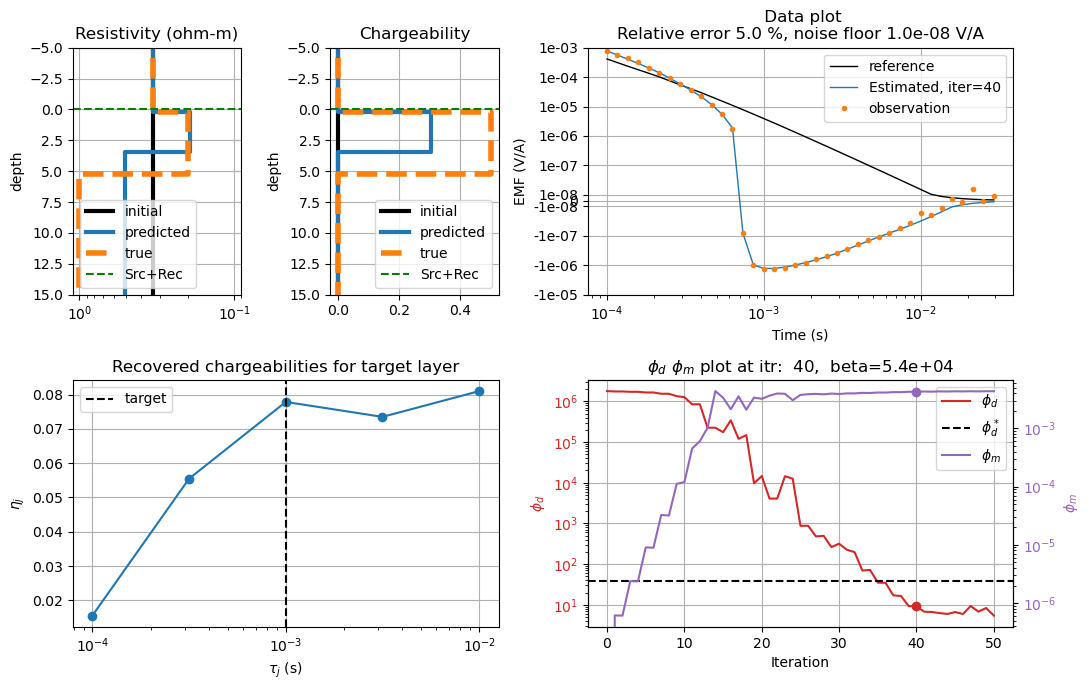

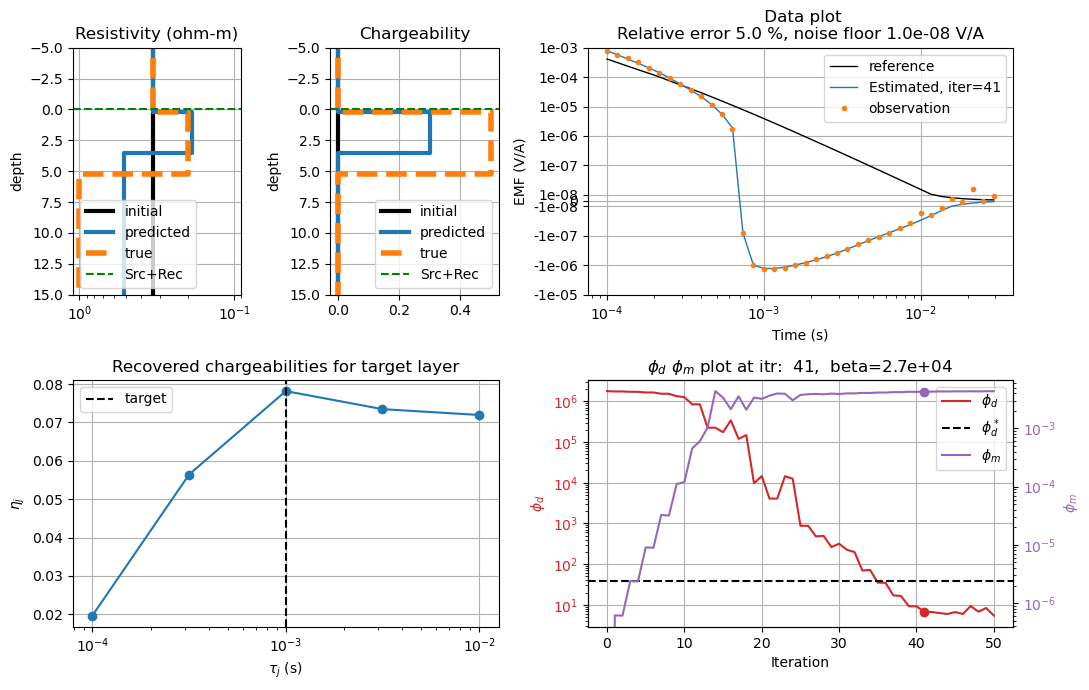

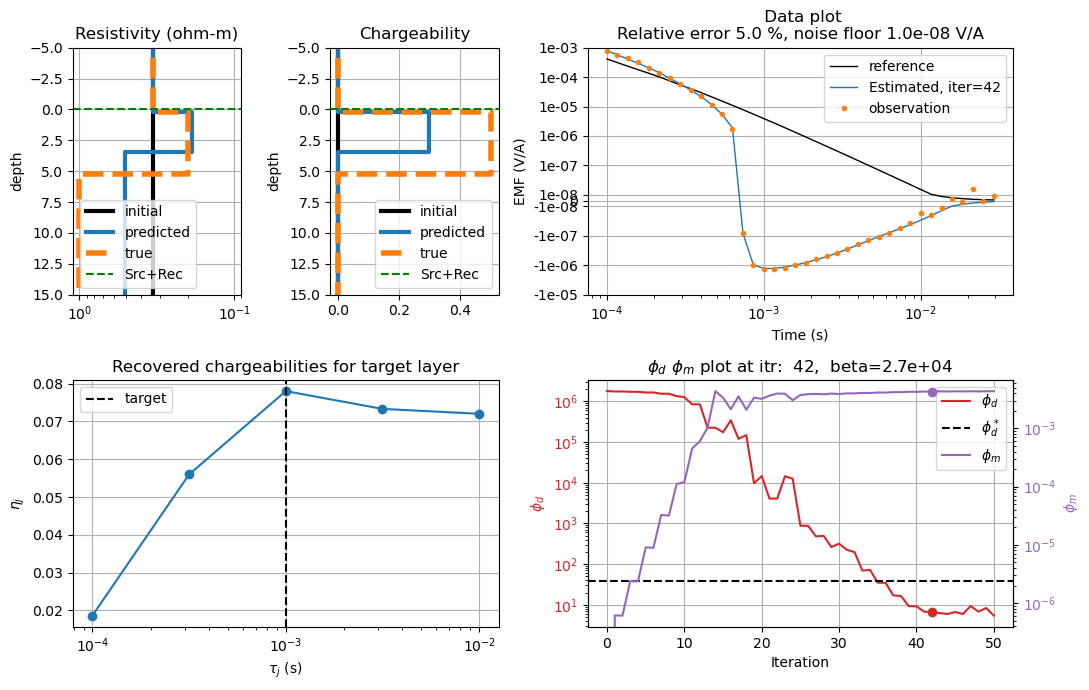

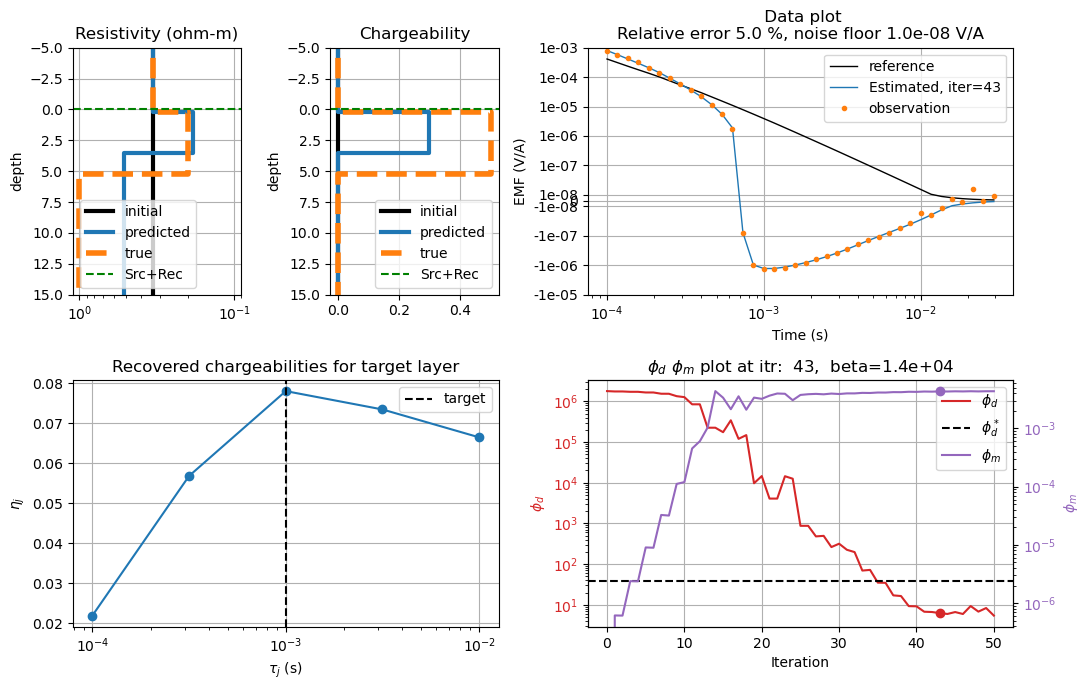

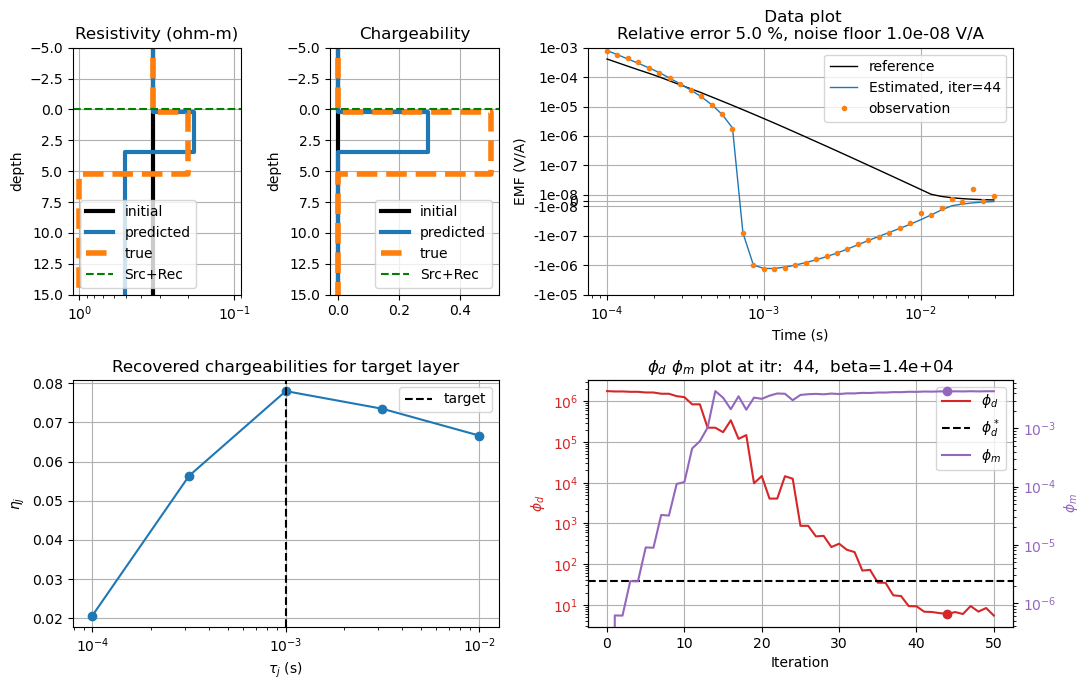

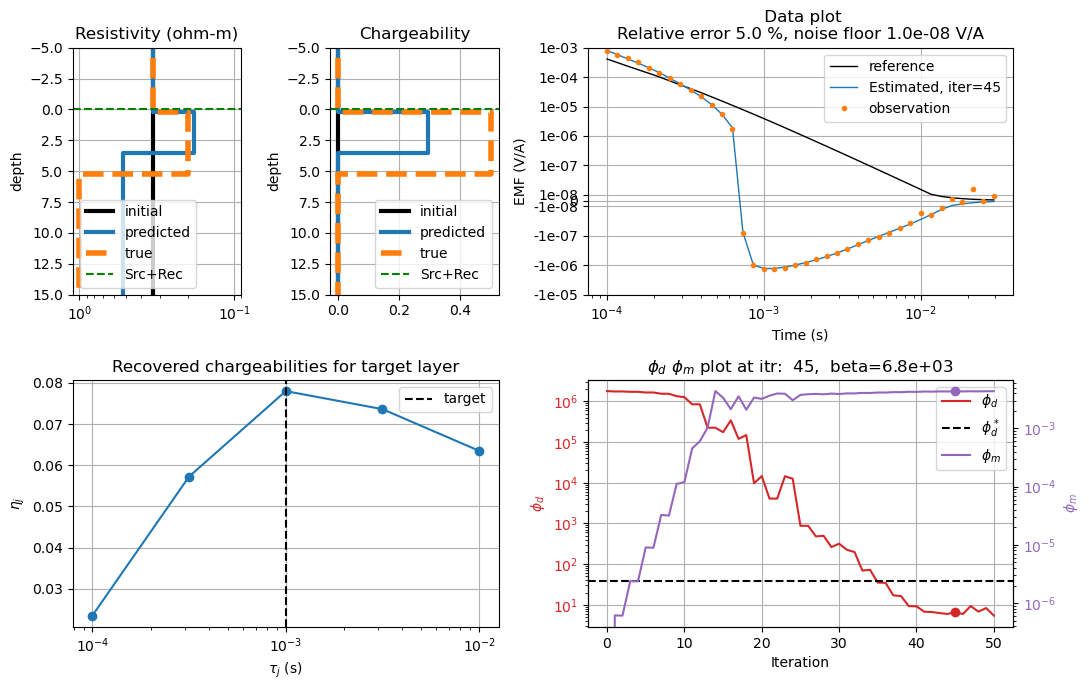

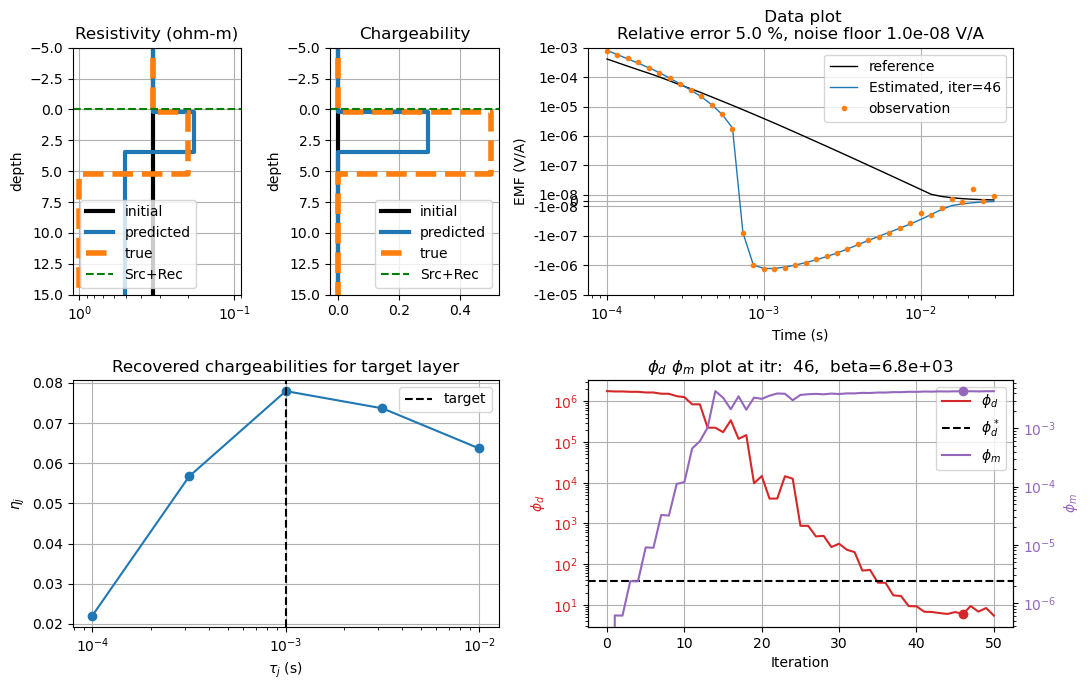

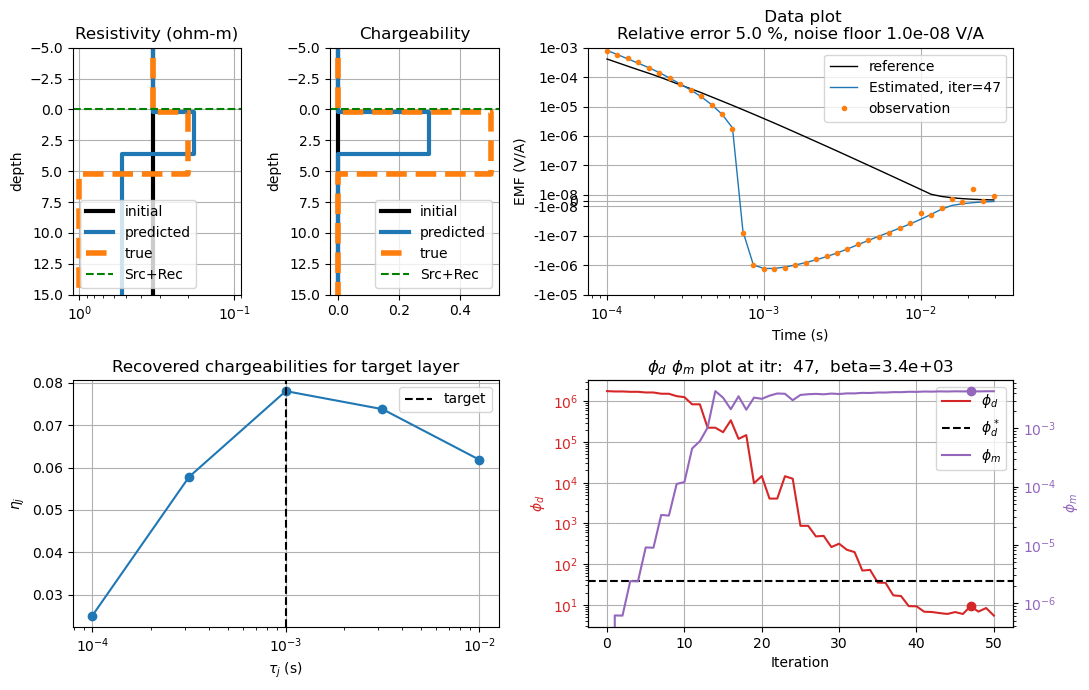

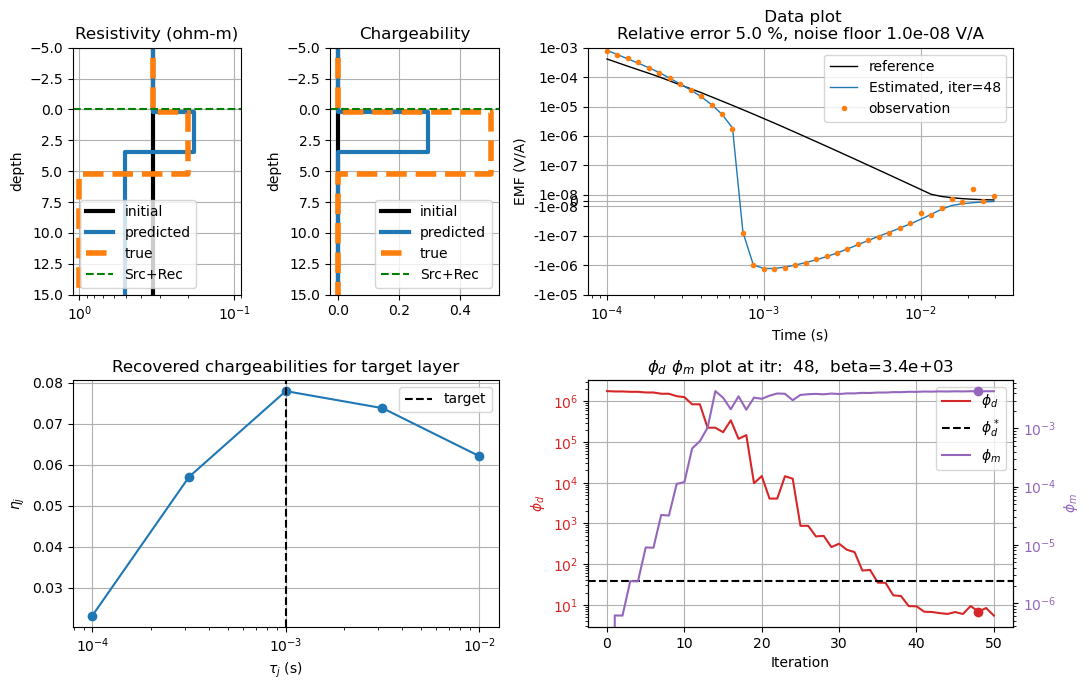

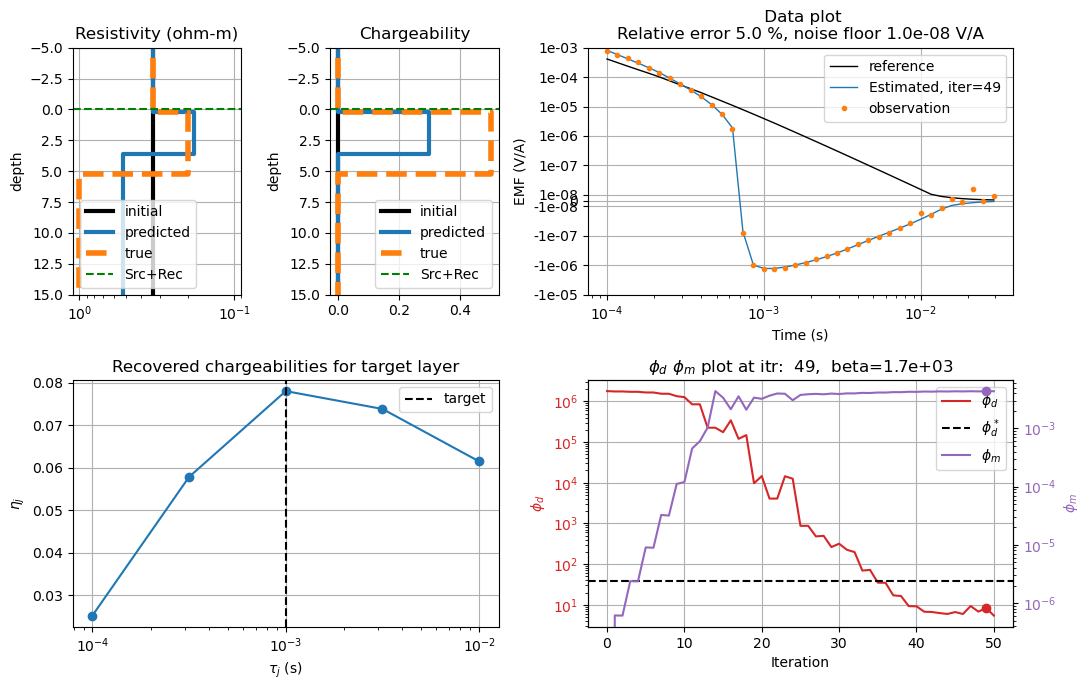

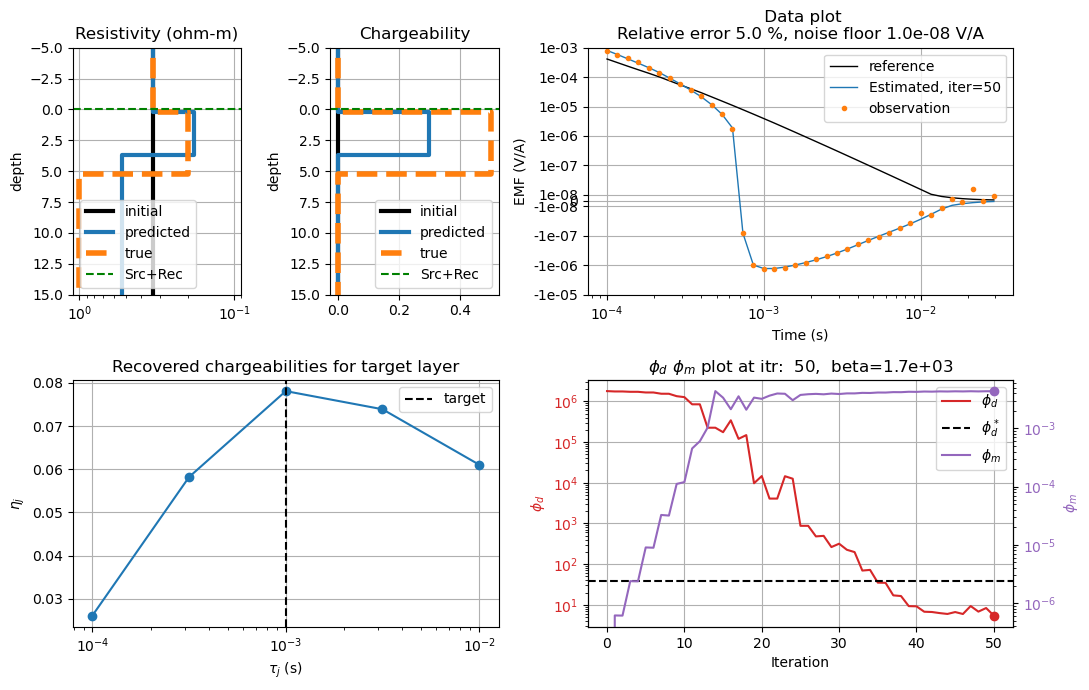

In [83]:
index_list = np.arange(cmp_itr)
output_folder = '32'
save_all_fields_images(index_list, output_folder= output_folder)


In [85]:
def images_to_gif(image_folder, output_gif, duration=1000, resize=(320, 240)):
    # Get all the image files in the folder
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')])
    # Open and resize the images
    images = [Image.open(os.path.join(image_folder, img)).resize(resize, Image.Resampling.LANCZOS) for img in image_files]
    # Save the images as an animated GIF
    images[0].save(output_gif, save_all=True, append_images=images[:], optimize=False, duration=duration, loop=0)


In [ ]:
# Provide the path to the input image folder, output video file, and desired duration (slower)
input_folder = r"32"
output_file = r"32_Parametric_Inv_DCS.gif"
duration = 1000  # 1000 ms per frame (1 second per frame)
resize = (1100, 700)  # New resolution (width, height)
# Call the function to convert the images to a GIF
images_to_gif(image_folder=input_folder, output_gif=output_file, duration=duration, resize=resize)

In [ ]:
def delete_all_images(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise ValueError(f"The folder {folder_path} does not exist.")
    
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    # Delete each image file
    for image_file in image_files:
        file_path = os.path.join(folder_path, image_file)
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

# Provide the path to the folder containing images
image_folder = 'images'

# Call the function to delete all images in the folder
delete_all_images(image_folder)